In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
device_list = tf.test.gpu_device_name()
device_list

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

# Prepare the data for modelisation

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset

We choose to work with the second method which consist of **Truncating Excess Data**,For example, if the EMG and IMU cover 10 seconds of recording, retain only the first 10 seconds of IPS data. Data was prepared on another notebook called `data_preparation`



In [ ]:
#/content/drive/My Drive/Master2_Paris8/Architecture complex/Project/dataset/method_2
dataset_base_path = "/content/drive/My Drive/Master2_Paris8/Architecture complex/Project/dataset/method_2"


df_emg = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_emg.csv"), index_col=0)
df_imu = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_imu.csv"), index_col=0)
df_ips = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_ips.csv"), index_col=0)
df_mocap = pd.read_csv(os.path.join(dataset_base_path, "aligned_datasets_mocap.csv"), index_col=0)


In [ ]:
print(df_emg.shape)
df_emg.head(5)

(113446, 66)


,R_Vlat_rms,R_RF_rms,R_ST_rms,R_TA_rms,L_Vlat_rms,L_RF_rms,L_ST_rms,L_TA_rms,R_MG_rms,R_LG_rms,...,R_MG_zc,R_LG_zc,R_SOL_zc,R_IL_zc,L_MG_zc,L_LG_zc,L_SOL_zc,L_IL_zc,category,person_id
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,3.154265,292.758180,65,38,3.696738,282.788085,56,34,3.684881,195.675659,...,3.497438,229.110718,51,27,3.413615,145.623779,29,21,back,1
1,3.677968,326.696778,69,37,4.208268,287.722779,62,32,4.657688,368.994141,...,9.854272,394.674683,51,23,5.228666,243.411255,48,24,back,1
2,3.800089,267.279053,50,26,3.798007,264.962768,44,20,3.792937,284.197999,...,5.891582,253.179930,35,12,4.752426,123.065186,34,12,back,1
3,3.374545,292.657471,61,39,4.385206,314.007569,66,32,5.642971,368.893433,...,7.399809,394.473266,40,24,2.422399,159.622193,38,24,back,1
4,4.138228,382.388306,64,34,3.381075,289.837644,61,32,5.003856,253.582763,...,6.837258,340.795900,52,32,4.945372,221.759034,34,22,back,1


### Useful functions

#### Data treatement

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


In [ ]:
def load_data(emg_df, imu_df, ips_df, mocap_df, label_df):

    X0 = emg_df.iloc[:,:-2].values
    X1 = imu_df.iloc[:,:-2].values
    X2 = ips_df.iloc[:,:-2].values
    X3 = mocap_df.iloc[:,:-2].values
    y = label_df.category.values
    X = [X0, X1, X2, X3]
    return X, y

#### Normalised data

In [ ]:
from tqdm import tqdm

def load_and_normalize_data(emg_df, imu_df, ips_df, mocap_df, label_df):
    """
    Load and normalize the datasets.

    Parameters:
        emg_df (pd.DataFrame): EMG data.
        imu_df (pd.DataFrame): IMU data.
        ips_df (pd.DataFrame): IPS data.
        mocap_df (pd.DataFrame): Motion Capture data.
        label_df (pd.DataFrame): Labels for the data.

    Returns:
        list: Normalized feature arrays for EMG, IMU, IPS, and MOCAP data.
        np.ndarray: Labels for the data.
    """
    # Normalize each dataset using Min-Max scaling
    def normalize(df):
        return (df - df.min()) / (df.max() - df.min())

    print("Normalizing datasets...")

    # Apply normalization and extract values
    X0 = normalize(emg_df.iloc[:, :-1]).values  # Exclude label column if present
    X1 = normalize(imu_df.iloc[:, :-1]).values
    X2 = normalize(ips_df.iloc[:, :-1]).values
    X3 = normalize(mocap_df.iloc[:, :-1]).values
    y = label_df.category.values  # Extract labels

    print("Normalization complete.")

    # Combine into a list
    X = [X0, X1, X2, X3]
    return X, y


#### Evaluation class

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
import tensorflow as tf

class Benchmark:
    def __init__(self, models, histories=None, models_name=None):
        """
        Initialize the Benchmark class.

        Args:
            models: List of trained models.
            histories: List of training history objects corresponding to each model (optional).
        """
        self.models = models
        self.histories = histories
        self.metrics = []

    def predict_classes(self, X_tests, y_test):
        """
        Generate predictions and predicted classes for each model.
        Stores y_pred and y_pred_classes for each model.

        Args:
            X_tests: List of test datasets matching the input format for each model.
            y_test: Ground truth labels for the test set.
        """
        self.y_preds = []
        self.y_pred_classes = []
        self.class_reports = []

        for i, model in enumerate(self.models):
            y_pred = model.predict(X_tests)
            y_pred_classes = np.argmax(y_pred, axis=-1)


            self.y_preds.append(y_pred)
            self.y_pred_classes.append(y_pred_classes)

            # Calculate evaluation metrics for the model
            accuracy = accuracy_score(y_test, y_pred_classes)
            precision = precision_score(y_test, y_pred_classes, average='weighted')
            recall = recall_score(y_test, y_pred_classes, average='weighted')
            f1 = f1_score(y_test, y_pred_classes, average='weighted')

            self.metrics.append({
                'Model': f'Model_{models_name[i]}',
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })

            # Add classification report for this model
            report = classification_report(y_test, y_pred_classes, output_dict=True)
            self.class_reports.append(report)

    def plot_confusion_matrices(self, y_test):
        """
        Plot confusion matrices for each model in subplots.

        Args:
            y_test: Ground truth labels for the test set.
        """
        num_models = len(self.models)
        plt.figure(figsize=(10, 3 * num_models))

        for i, y_pred_classes in enumerate(self.y_pred_classes):
            cm = confusion_matrix(y_test, y_pred_classes)
            plt.subplot(num_models, 1, i + 1)
            sns.heatmap(
                cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test)
            )
            plt.title(f"Confusion Matrix for Model_{models_name[i]}")
            plt.xlabel("Predicted")
            plt.ylabel("True")

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, y_test):
        """
        Plot ROC curves for all models in subplots.

        Args:
            y_test: Ground truth labels for the test set.
        """
        y_test_binary = tf.keras.utils.to_categorical(y_test, num_classes=self.y_preds[0].shape[-1])
        num_models = len(self.models)
        plt.figure(figsize=(10, 3 * num_models))

        for i, y_pred in enumerate(self.y_preds):
            plt.subplot(num_models, 1, i + 1)
            for j in range(y_pred.shape[-1]):
                fpr, tpr, _ = roc_curve(y_test_binary[:, j], y_pred[:, j])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"Class {j} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
            plt.title(f"ROC Curve for Model_{models_name[i]}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()

    def plot_training_histories(self):
        """
        Plot training and validation metrics for all models in separate subplots.
        """
        if not self.histories:
            print("No training histories provided.")
            return

        num_models = len(self.histories)
        plt.figure(figsize=(10, 3 * num_models))

        for i, history in enumerate(self.histories):
            # Plot Loss
            plt.subplot(num_models, 2, 2 * i + 1)
            plt.plot(history.history['loss'], label='Train Loss')
            if 'val_loss' in history.history:
                plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f"Loss for Model_{models_name[i]}")
            plt.ylabel("Loss")
            plt.xlabel("Epoch")
            plt.legend()

            # Plot Accuracy
            plt.subplot(num_models, 2, 2 * i + 2)
            plt.plot(history.history['accuracy'], label='Train Accuracy')
            if 'val_accuracy' in history.history:
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title(f"Accuracy for Model_{models_name[i]}")
            plt.ylabel("Accuracy")
            plt.xlabel("Epoch")
            plt.legend()

        plt.tight_layout()
        plt.show()

    def get_metrics_dataframe(self):
        """
        Create a DataFrame summarizing evaluation metrics for all models.

        Returns:
            DataFrame containing evaluation metrics for all models.
        """
        return pd.DataFrame(self.metrics)

    def print_classification_reports(self):
        """
        Print classification reports for each model.
        """
        for i, report in enumerate(self.class_reports):
            print(f"Classification Report for Model_{models_name[i]}:")
            print(pd.DataFrame(report).transpose())
            print("\n")


# Modelisation

In [ ]:
# merge data for unified model after train test splits
def merge_modalities(X_list):
    """
    The features of all modes are combined into an overall feature matrix.
    """
    return tf.concat(X_list, axis=-1)

In [ ]:
label_df = df_emg[['category']] # It is the same for imu, ips and moap
person_df = df_emg[['person_id']]
X, y = load_data(df_emg, df_imu, df_ips, df_mocap, label_df)

le = LabelEncoder()
y = le.fit_transform(y)

## Architecture Unified

### Prepare data for split

#### Train Test split of sckit learn 80%-20% repartition

In [ ]:
from sklearn.model_selection import train_test_split

dataloader = train_test_split(*X,y, test_size=0.2, random_state=42)

In [ ]:
num_categories = len(X)
X_train = [np.array(dataloader[i * 2]) for i in range(num_categories)]
X_test = [np.array(dataloader[i * 2 + 1]) for i in range(num_categories)]
y_train = np.array(dataloader[-2])
y_test = np.array(dataloader[-1])
X_train = merge_modalities(X_train)
X_test = merge_modalities(X_test)

In [ ]:
X_train.shape

TensorShape([90756, 953])

#### Leave-One-Group-Out (LOGO) repartition

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def logo_split(X_list, y, person_df, train_patients_count=20):
    """
    Splits data into training and testing sets based on patient IDs.

    Args:
        X_list: List of arrays, one for each modality.
        y: Array of labels.
        person_df: DataFrame containing the 'person_id' column.
        train_patients_count: Number of patients to include in the training set (default=20).

    Returns:
        X_train: Array for training data.
        X_test: Array for testing data.
        y_train: Labels for training data.
        y_test: Labels for testing data.
    """
    # Extract unique patient IDs and sort for consistency
    unique_patients = np.sort(person_df['person_id'].unique())

    # Split patients into train and test groups
    train_patients = unique_patients[:train_patients_count]
    test_patients = unique_patients[train_patients_count:]

    # Create masks for train and test
    train_mask = person_df['person_id'].isin(train_patients).values
    test_mask = person_df['person_id'].isin(test_patients).values

    # Split each modality separately based on the masks
    X_train = [X[train_mask] for X in X_list]
    X_test = [X[test_mask] for X in X_list]

    # Split labels
    y_train = y[train_mask]
    y_test = y[test_mask]

    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = logo_split(X, y, person_df)
X_train = merge_modalities(X_train)
X_test = merge_modalities(X_test)

### Model preparition

In [ ]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.regularizers import l2

def build_unified_model(input_shape, dropout_rate=0.3, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    """
    Architecture Unifiée
    """

    input_layer = Input(shape=(input_shape,), name="Unified_Input")


    x = layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01))(input_layer)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu')(x)


    output_layer = layers.Dense(4, activation='softmax')(x)  #4 catégories


    model = models.Model(inputs=input_layer, outputs=output_layer)


    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


### Run model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = build_unified_model(input_shape=X_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Converting probabilities to prediction categories

#  Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.7075 - loss: 4.9375 - val_accuracy: 0.9450 - val_loss: 0.7114
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.9094 - loss: 0.7257 - val_accuracy: 0.9660 - val_loss: 0.3438
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9319 - loss: 0.4068 - val_accuracy: 0.9684 - val_loss: 0.2156
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9362 - loss: 0.3267 - val_accuracy: 0.9717 - val_loss: 0.2022
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9416 - loss: 0.2952 - val_accuracy: 0.9679 - val_loss: 0.1929
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9429 - loss: 0.2792 - val_accuracy: 0.9728 - val_loss: 0.1932
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9257 - loss: 0.3141 - val_accuracy: 0.9732 - val_loss: 0.1899
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9383 - loss: 

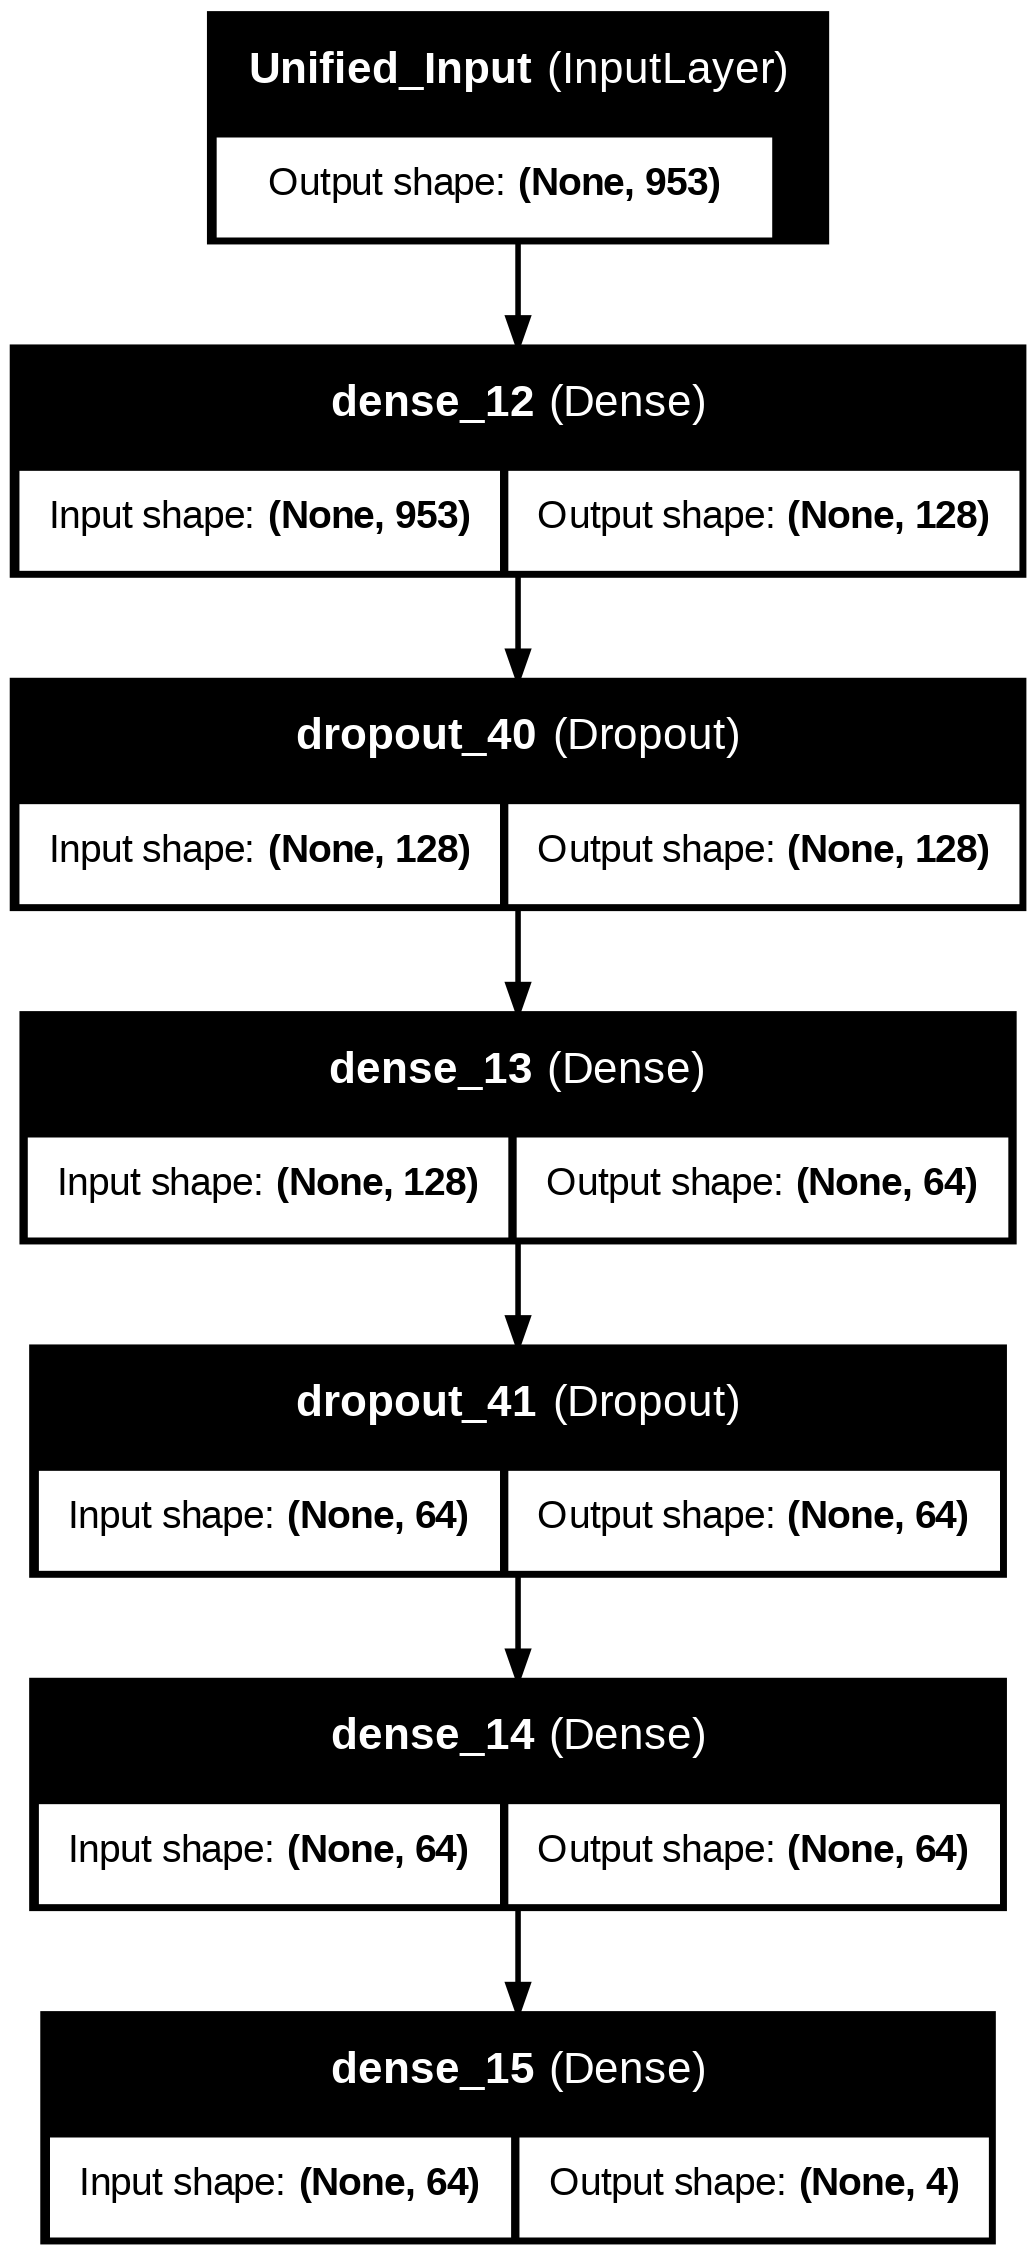

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Model Evaluation with train_test_split

In [ ]:
# Example models and datasets
models = [model]  # List of trained models
histories = [history] # List of training histories (optional)

models_name= ['Unified model'] # List of model names
X_tests = X_test  # Test input datasets
y_test = y_test  # Ground truth labels

# Initialize Benchmark class
benchmark = Benchmark(models, histories, models_name)

In [ ]:

# Generate predictions
benchmark.predict_classes(X_tests, y_test)


592/592 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Print classification reports
benchmark.print_classification_reports()

Classification Report for Model_Unified model:
              precision    recall  f1-score       support
0              0.985871  0.958623  0.972056   6187.000000
1              0.992404  0.985303  0.988840   5171.000000
2              0.979289  0.982892  0.981087   5436.000000
3              0.964004  0.994742  0.979132   5896.000000
accuracy       0.979903  0.979903  0.979903      0.979903
macro avg      0.980392  0.980390  0.980279  22690.000000
weighted avg   0.980101  0.979903  0.979883  22690.000000




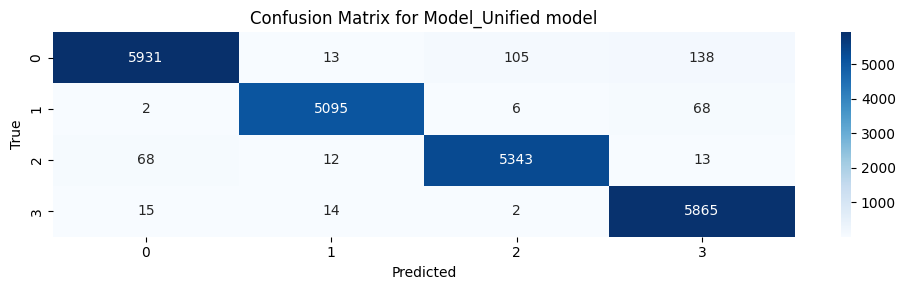

In [ ]:

# Plot confusion matrices
benchmark.plot_confusion_matrices(y_test)


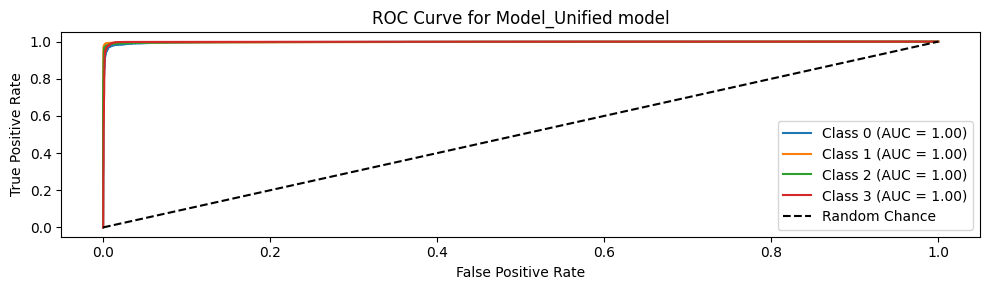

In [ ]:

# Plot ROC curves
benchmark.plot_roc_curves(y_test)


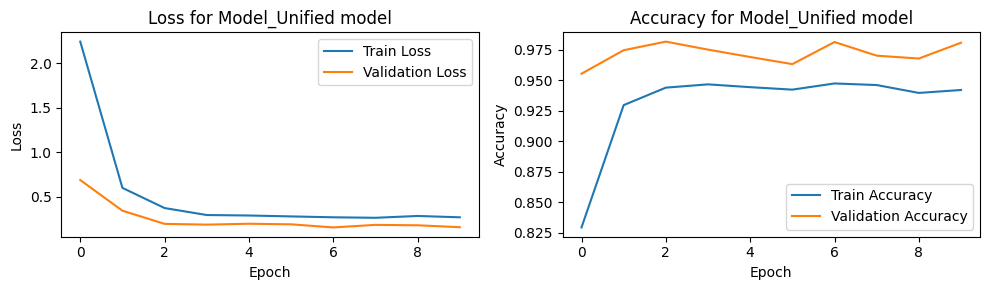

In [ ]:

# Plot training histories
benchmark.plot_training_histories()


In [ ]:
# Get metrics DataFrame
metrics_df = benchmark.get_metrics_dataframe()
metrics_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Model_Unified model,0.911572,0.922253,0.911572,0.909175


### Save Model

In [ ]:
import pickle

# Save model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Model Optimisation

#### Random Search

In [ ]:
import random
from tensorflow.keras import layers, models, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import itertools

def random_search_unified_model(X, Y, split_methods,  hyperparameter_grid, n_samples=20):
    """
    Perform random search on the unified model.
    """
    results = []

    # Generate all combinations of hyperparameters
    all_hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

    # Randomly sample n_samples combinations
    sampled_combinations = random.sample(all_hyperparameter_combinations, min(n_samples, len(all_hyperparameter_combinations)))

    # Iterate over split methods
    for split_method in split_methods:
        # Perform the split
        if split_method == "logo_split":
            X_train, X_test, y_train, y_test = logo_split(X, y, person_df)
        else:
            X_ = merge_modalities(X)
            X_train, X_test, y_train, y_test = train_test_split(X_,y, test_size=0.2, random_state=42)
        # Iterate over sampled hyperparameter combinations
        for hyperparams in sampled_combinations:

            # Unpack hyperparameters
            hyperparam_dict = dict(zip(hyperparameter_grid.keys(), hyperparams))

            try:
                # Build and compile the model with the sampled hyperparameters
                model = build_unified_model(
                    input_shape=X_train.shape[1],
                    dropout_rate=hyperparam_dict['dropout_rate'],
                    optimizer=hyperparam_dict['optimizer'],
                    loss=hyperparam_dict['loss'],
                    metrics=hyperparam_dict['metrics']
                )

                # Early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                # Train the model
                history = model.fit(
                    X_train, y_train,
                    epochs=hyperparam_dict['epochs'],
                    batch_size=hyperparam_dict['batch_size'],
                    callbacks=[early_stopping],
                    verbose=0
                )

                # Record the results
                results.append({
                    'hyperparameters': hyperparam_dict,
                    'model_type': 'unified',
                    'split_method': split_method,
                    'accuracy': history.history['accuracy'][-1],

                })

            except Exception as e:
                print(f"Error with configuration {hyperparam_dict}: {e}")

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    return results_df

# Define the hyperparameter grid
hyperparameter_grid = {
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'sgd'],
    'loss': ['sparse_categorical_crossentropy'],
    'metrics': [['accuracy']],
    'epochs': [8, 10],
    'batch_size': [32, 64],

}
split_methods = ["logo_split", "train_test_split"]
# Perform random search
results_df = random_search_unified_model(
    X, y, split_methods,
    hyperparameter_grid=hyperparameter_grid,
    n_samples=20
)


## Architectuer Multi-Modale

### Prepare data for split

#### Split data by categories

We tried to split the data in a way to respect the sequence of each category, without using train_test_split of sckit-learn



In [ ]:
def split_data_by_category(X, y, test_size=0.2):
    # Store the training data and labels
    X_train = []
    y_train = []
    X_test = []
    y_test = []


    # Convert categories to numeric labels based on the LabelEncoder
    category_labels = [0, 1, 2, 3]  # This is based on the ordering of the labels in LabelEncoder

    for category_label in  category_labels:
        # Filter data for the current category using the numeric label
        category_indices = np.where(y == category_label)[0]
        X_category = [x[category_indices] for x in X]
        y_category = y[category_indices]



        # Calculate the split index based on the test_size
        split_idx = int(len(X_category[0]) * (1 - test_size))  # Ensure the split respects time order

        # Split the data into training and testing sets for this category
        X_train_category = [x[:split_idx] for x in X_category]
        y_train_category = y_category[:split_idx]

        X_test_category = [x[split_idx:] for x in X_category]
        y_test_category = y_category[split_idx:]

        # Concatenate the training and testing data for each category
        X_train.append(X_train_category)
        y_train.append(y_train_category)
        X_test.append(X_test_category)
        y_test.append(y_test_category)



    # Concatenate the results across all categories
    X_train = [np.concatenate([X_train[i][j] for i in range(len(X_train))], axis=0) for j in range(len(X))]
    X_test = [np.concatenate([X_test[i][j] for i in range(len(X_test))], axis=0) for j in range(len(X))]

    y_train = [np.concatenate([y_train[i] for i in range(len(y_train))], axis=0)][0]
    y_test = [np.concatenate([y_test[i] for i in range(len(y_test))], axis=0)][0]

    return X_train, X_test, y_train, y_test

#### Functions to choose split method

In [ ]:
def preprocess_data_with_split(X, y, split_method, person_df=person_df, test_size=0.2, random_state=42):
    """
    Preprocess and split data using a specified split method, then reshape the results.

    Parameters:
    - X: List of numpy arrays or equivalent data to split (categories).
    - y: Target data to split.
    - split_method: String indicating the split method to use ("logo_split", "train_test_split", "split_data_by_category").
    - person_df: DataFrame for Leave-One-Group-Out split (required for "logo_split").
    - test_size: Proportion of test data for "train_test_split".
    - random_state: Random seed for "train_test_split".

    Returns:
    - Split and reshaped data: X_train, X_test, y_train, y_test.
    """
    if split_method == "logo_split":
        if person_df is None:
            raise ValueError("person_df must be provided for logo_split.")
        X_train, X_test, y_train, y_test = logo_split(X, y, person_df)
    elif split_method == "train_test_split":
        dataloader = train_test_split(*X, y, test_size=test_size, random_state=random_state)
        num_categories = len(X)
        X_train = [np.array(dataloader[i * 2]) for i in range(num_categories)]
        X_test = [np.array(dataloader[i * 2 + 1]) for i in range(num_categories)]
        y_train = np.array(dataloader[-2])
        y_test = np.array(dataloader[-1])
    elif split_method == "split_data_by_category":
        X_train, X_test, y_train, y_test = split_data_by_category(X, y)
    else:
        raise ValueError(f"Unknown split method: {split_method}")

    # Reshape arrays
    X_train = [x.reshape(x.shape[0], 1, x.shape[1]) for x in X_train]
    X_test = [x.reshape(x.shape[0], 1, x.shape[1]) for x in X_test]

    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = preprocess_data_with_split(
    X, y, split_method="split_data_by_category", test_size=0.2, random_state=42
)
X0_train, X1_train, X2_train, X3_train = X_train
X0_test, X1_test, X2_test, X3_test = X_test
print("X0_train shape:", X0_train.shape)
print("X1_train shape:", X1_train.shape)
print("X2_train shape:", X2_train.shape)
print("y_train shape:", y_train.shape)

# Use "train_test_split" method
X_train, X_test, y_train, y_test = preprocess_data_with_split(
    X, y, split_method="train_test_split", test_size=0.2, random_state=42
)
X0_train, X1_train, X2_train, X3_train = X_train
X0_test, X1_test, X2_test, X3_test = X_test
print("X0_train shape:", X0_train.shape)
print("X1_train shape:", X1_train.shape)
print("X2_train shape:", X2_train.shape)
print("y_train shape:", y_train.shape)



# Use "logo_split" method
X_train, X_test, y_train, y_test = preprocess_data_with_split(
    X, y, split_method="logo_split", person_df=person_df
)
X0_train, X1_train, X2_train, X3_train = X_train
X0_test, X1_test, X2_test, X3_test = X_test
print("X0_train shape:", X0_train.shape)
print("X1_train shape:", X1_train.shape)
print("X2_train shape:", X2_train.shape)
print("y_train shape:", y_train.shape)


X0_train shape: (90756, 1, 64)
X1_train shape: (90756, 1, 54)
X2_train shape: (90756, 1, 682)
y_train shape: (90756,)
X0_train shape: (90756, 1, 64)
X1_train shape: (90756, 1, 54)
X2_train shape: (90756, 1, 682)
y_train shape: (90756,)
X0_train shape: (94504, 1, 64)
X1_train shape: (94504, 1, 54)
X2_train shape: (94504, 1, 682)
y_train shape: (94504,)


### Model preparition

#### Simple model

In [ ]:
import tensorflow as tf
import numpy as np

def create_and_train_model(input_shapes, num_classes, dropout_rate=0.5,X_train=None,y_train=None,
                           kernel_regularizer=tf.keras.regularizers.l2(0.001), optimizer='adam',
                           metrics=['accuracy'],  validation_split=0.2, epochs=20, early_stopping = None):
    """
    Create and train a concatenated neural network model.

    Parameters:
        input_shapes (list of tuple): A list of input shapes for each input tensor.
        num_classes (int): Number of output classes for classification.
        dense_layers_config (list of dict): List of dense layer configurations, e.g., [{'units': 100, 'activation': 'relu'}, ...].
        dropout_rate (float): Dropout rate for regularization.
        kernel_regularizer (tf.keras.regularizers.Regularizer): Regularizer for the Dense layers.
        optimizer (str or tf.keras.optimizers.Optimizer): Optimizer for training.
        loss (str or tf.keras.losses.Loss): Loss function for training.
        metrics (list): List of metrics to evaluate during training.
        X_train (list of np.ndarray): List of training input data arrays corresponding to input_shapes.
        y_train (np.ndarray): Training labels.
        validation_split (float): Fraction of training data to use as validation data.
        epochs (int): Number of training epochs.

    Returns:
        tf.keras.Model: The trained Keras model.
        tf.keras.callbacks.History: Training history object.
    """


    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'tanh'},
        {'units': 50, 'activation': 'tanh'}
    ]
    # Create input layers
    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]

    # Concatenate inputs along the last axis
    x = tf.keras.layers.concatenate(inputs, axis=-1)

    # Flatten the concatenated tensor
    x = tf.keras.layers.Flatten()(x)

    # Add dense layers with specified configurations
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Add output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Construct the model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)

    # Display the model summary
    model.summary()

    # Plot the model architecture

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


#### CNN model

In [ ]:
def create_and_train_cnn_model(input_shapes, num_classes,
                               dropout_rate=0.5, X_train=None, y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                               optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, early_stopping = None):
    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'relu'},
        {'units': 50, 'activation': 'relu'}
    ]

    # Define convolutional layer configurations for the CNN model
    conv_layers_config = [
        {'filters': 32, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3},
        {'filters': 64, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3}
    ]
    # Apply convolutional layers to each input
    processed_inputs = []
    for input_tensor in inputs:
        x = input_tensor
        for layer_config in conv_layers_config:
            x = tf.keras.layers.Conv1D(
                filters=layer_config['filters'],
                kernel_size=layer_config['kernel_size'],
                activation=layer_config.get('activation', 'relu'),
                kernel_regularizer=kernel_regularizer,
                padding='same'
            )(x)

            if x.shape[1] > 1 and 'pool_size' in layer_config:
                x = tf.keras.layers.MaxPooling1D(pool_size=layer_config['pool_size'])(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        processed_inputs.append(tf.keras.layers.Flatten()(x))

    # Concatenate flattened outputs
    x = tf.keras.layers.concatenate(processed_inputs, axis=-1)

    # Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


#### LSTM model

In [ ]:
def create_and_train_lstm_model(input_shapes, num_classes,
                                dropout_rate=0.5,X_train=None,y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, early_stopping = None):
    """
    Create and train an LSTM-based model.

    Parameters:
        input_shapes (list of tuple): A list of input shapes for each input tensor.
        num_classes (int): Number of output classes for classification.
        lstm_layers_config (list of dict): List of LSTM layer configurations,
            e.g., [{'units': 64, 'return_sequences': True}, ...].
        dense_layers_config (list of dict): List of dense layer configurations.
        dropout_rate (float): Dropout rate for regularization.
        kernel_regularizer (tf.keras.regularizers.Regularizer): Regularizer for the Dense layers.
        optimizer (str or tf.keras.optimizers.Optimizer): Optimizer for training.
        metrics (list): List of metrics to evaluate during training.
        validation_split (float): Fraction of training data to use as validation data.
        epochs (int): Number of training epochs.

    Returns:
        tf.keras.Model: The trained Keras model.
        tf.keras.callbacks.History: Training history object.
    """

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 100, 'activation': 'relu'},
        {'units': 50, 'activation': 'relu'}
    ]


    # Define LSTM layer configurations for the LSTM model
    lstm_layers_config = [
        {'units': 64, 'return_sequences': True},
        {'units': 32, 'return_sequences': False}
    ]

    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]
    x = tf.keras.layers.concatenate(inputs, axis=-1)


    # Apply LSTM layers
    for layer_config in lstm_layers_config:
        x = tf.keras.layers.LSTM(
            units=layer_config['units'],
            return_sequences=layer_config.get('return_sequences', False),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=output)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


#### hybrid version of CNN and LSTM

In [ ]:
import tensorflow as tf

def create_and_train_cnn_lstm_model(input_shapes, num_classes,
                                    dropout_rate=0.5, X_train=None, y_train=None, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    optimizer='adam', metrics=['accuracy'], validation_split=0.2, epochs=20, batch_size=32, early_stopping = None):


    # Define convolutional layer configurations for the hybrid model
    conv_layers_config = [
        {'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3},
    ]

    # Define LSTM layer configurations for the hybrid model
    lstm_layers_config = [
        {'units': 32, 'return_sequences': True},
    ]

    # Define dense layer configurations
    dense_layers_config = [
        {'units': 64, 'activation': 'relu'},
        {'units': 32, 'activation': 'relu'}
    ]

    inputs = [tf.keras.Input(shape=shape) for shape in input_shapes]

    processed_inputs = []
    for input_tensor in inputs:
        x = input_tensor
        # Apply Conv1D layers
        for layer_config in conv_layers_config:
            x = tf.keras.layers.Conv1D(
                filters=layer_config['filters'],
                kernel_size=layer_config['kernel_size'],
                activation=layer_config.get('activation', 'relu'),
                kernel_regularizer=kernel_regularizer,
                padding='same'
            )(x)


            if x.shape[1] > 1 and 'pool_size' in layer_config:
                x = tf.keras.layers.MaxPooling1D(pool_size=layer_config['pool_size'])(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        # Apply LSTM layers
        for layer_config in lstm_layers_config:
            x = tf.keras.layers.LSTM(
                units=layer_config['units'],
                return_sequences=layer_config.get('return_sequences', False),
                kernel_regularizer=kernel_regularizer
            )(x)
            x = tf.keras.layers.Dropout(dropout_rate)(x)

        processed_inputs.append(tf.keras.layers.Flatten()(x))

    # Concatenate flattened outputs
    x = tf.keras.layers.concatenate(processed_inputs, axis=-1)

    # Apply Dense layers
    for layer_config in dense_layers_config:
        x = tf.keras.layers.Dense(
            units=layer_config['units'],
            activation=layer_config.get('activation', 'relu'),
            kernel_regularizer=kernel_regularizer
        )(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Build model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # Compile the model
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)
    model.summary()

    # Train the model if training data is provided
    if X_train is not None and y_train is not None:
        history = model.fit(
            x=X_train, y=y_train,
            validation_split=validation_split,
            epochs=epochs
        )
        return model, history
    else:
        return model, None


### Run model

#### simple model

In [ ]:
# Define input shapes for the four inputs
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

# Number of classes for the output
num_classes = len(np.unique(y_train))

# Call the function to create and train the model
model, history = create_and_train_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.5,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_25            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_27            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 1, 953)         │              0 │ input_layer_24[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_25[0][0],  │
│                           │                        │                │ input_layer_26[0][0],  │
│                           │                        │                │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 953)            │              0 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_158 (Dense)         │ (None, 100)            │         95,400 │ flatten_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_98 (Dropout)      │ (None, 100)            │              0 │ dense_158[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_159 (Dense)         │ (None, 50)             │          5,050 │ dropout_98[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_99 (Dropout)      │ (None, 50)             │              0 │ dense_159[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_160 (Dense)         │ (None, 4)              │            204 │ dropout_99[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 100,654 (393.18 KB)

 Trainable params: 100,654 (393.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6677 - loss: 0.9480 - val_accuracy: 0.8742 - val_loss: 0.4224
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8229 - loss: 0.5559 - val_accuracy: 0.9067 - val_loss: 0.3415
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8570 - loss: 0.4744 - val_accuracy: 0.9024 - val_loss: 0.3382
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8484 - loss: 0.4804 - val_accuracy: 0.9112 - val_loss: 0.3086
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8615 - loss: 0.4570 - val_accuracy: 0.9219 - val_loss: 0.3052
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8490 - loss: 0.4851 - val_accuracy: 0.8949 - val_loss: 0.3431
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8536 - loss: 0.4683 - val_accuracy: 0.9155 - val_loss: 0.3009
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8661 - loss: 0.44

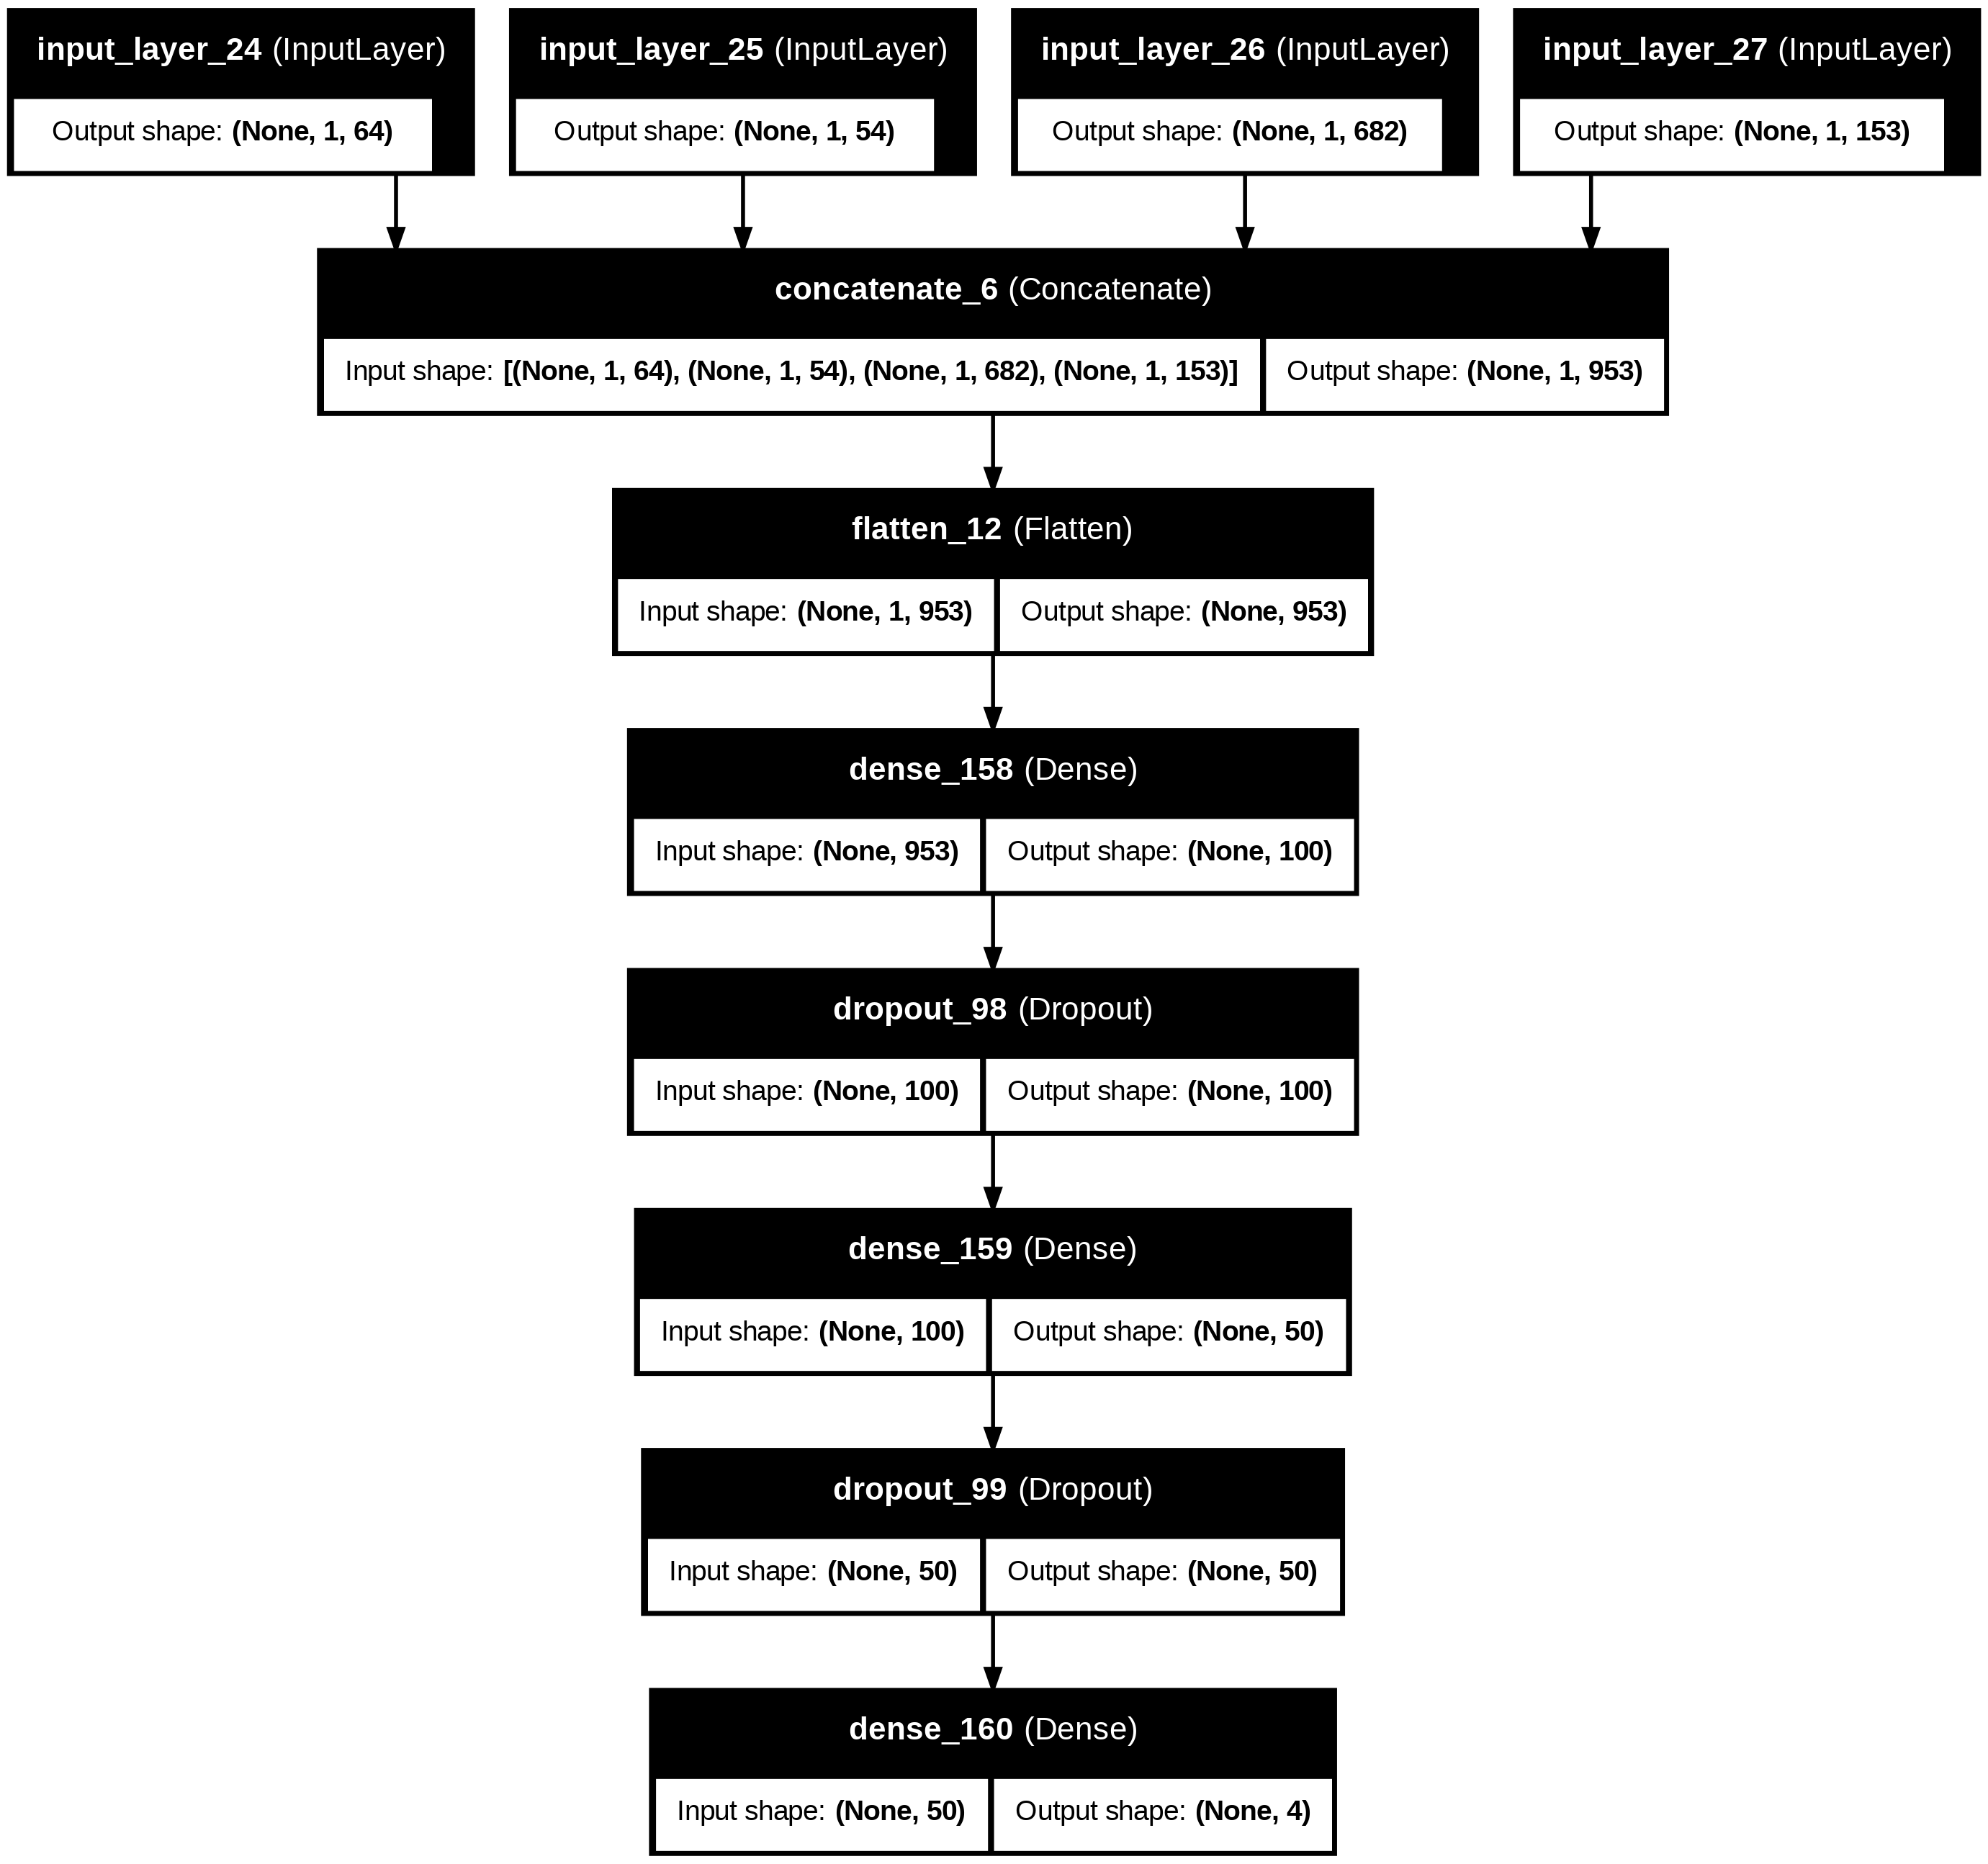

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

#### CNN model

In [ ]:
# Define input shapes for the four inputs
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]


# Create the CNN model
cnn_model, cnn_history = create_and_train_cnn_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.5,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_29            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_30            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_31            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 1, 32)          │          6,176 │ input_layer_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_18 (Conv1D)        │ (None, 1, 32)          │          5,216 │ input_layer_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_20 (Conv1D)        │ (None, 1, 32)          │         65,504 │ input_layer_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)        │ (None, 1, 32)          │         14,720 │ input_layer_31[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_100 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_102 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_104 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_106 (Dropout)     │ (None, 1, 32)          │              0 │ conv1d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_100[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_19 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_102[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_21 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_104[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 1, 64)          │          6,208 │ dropout_106[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_101 (Dropout)     │ (None, 1, 64)          │              0 │ conv1d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_103 (Dropout)

 Total params: 147,402 (575.79 KB)

 Trainable params: 147,402 (575.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.3617 - loss: 7.2493 - val_accuracy: 0.7407 - val_loss: 0.8970
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7807 - loss: 0.8484 - val_accuracy: 0.9723 - val_loss: 0.3224
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9460 - loss: 0.4464 - val_accuracy: 0.9924 - val_loss: 0.2101
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9650 - loss: 0.3095 - val_accuracy: 0.9951 - val_loss: 0.1582
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9718 - loss: 0.2461 - val_accuracy: 0.9957 - val_loss: 0.1355
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9713 - loss: 0.2240 - val_accuracy: 0.9949 - val_loss: 0.1270
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9728 - loss: 0.2124 - val_accuracy: 0.9942 - val_loss: 0.1189
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9748 - loss: 0

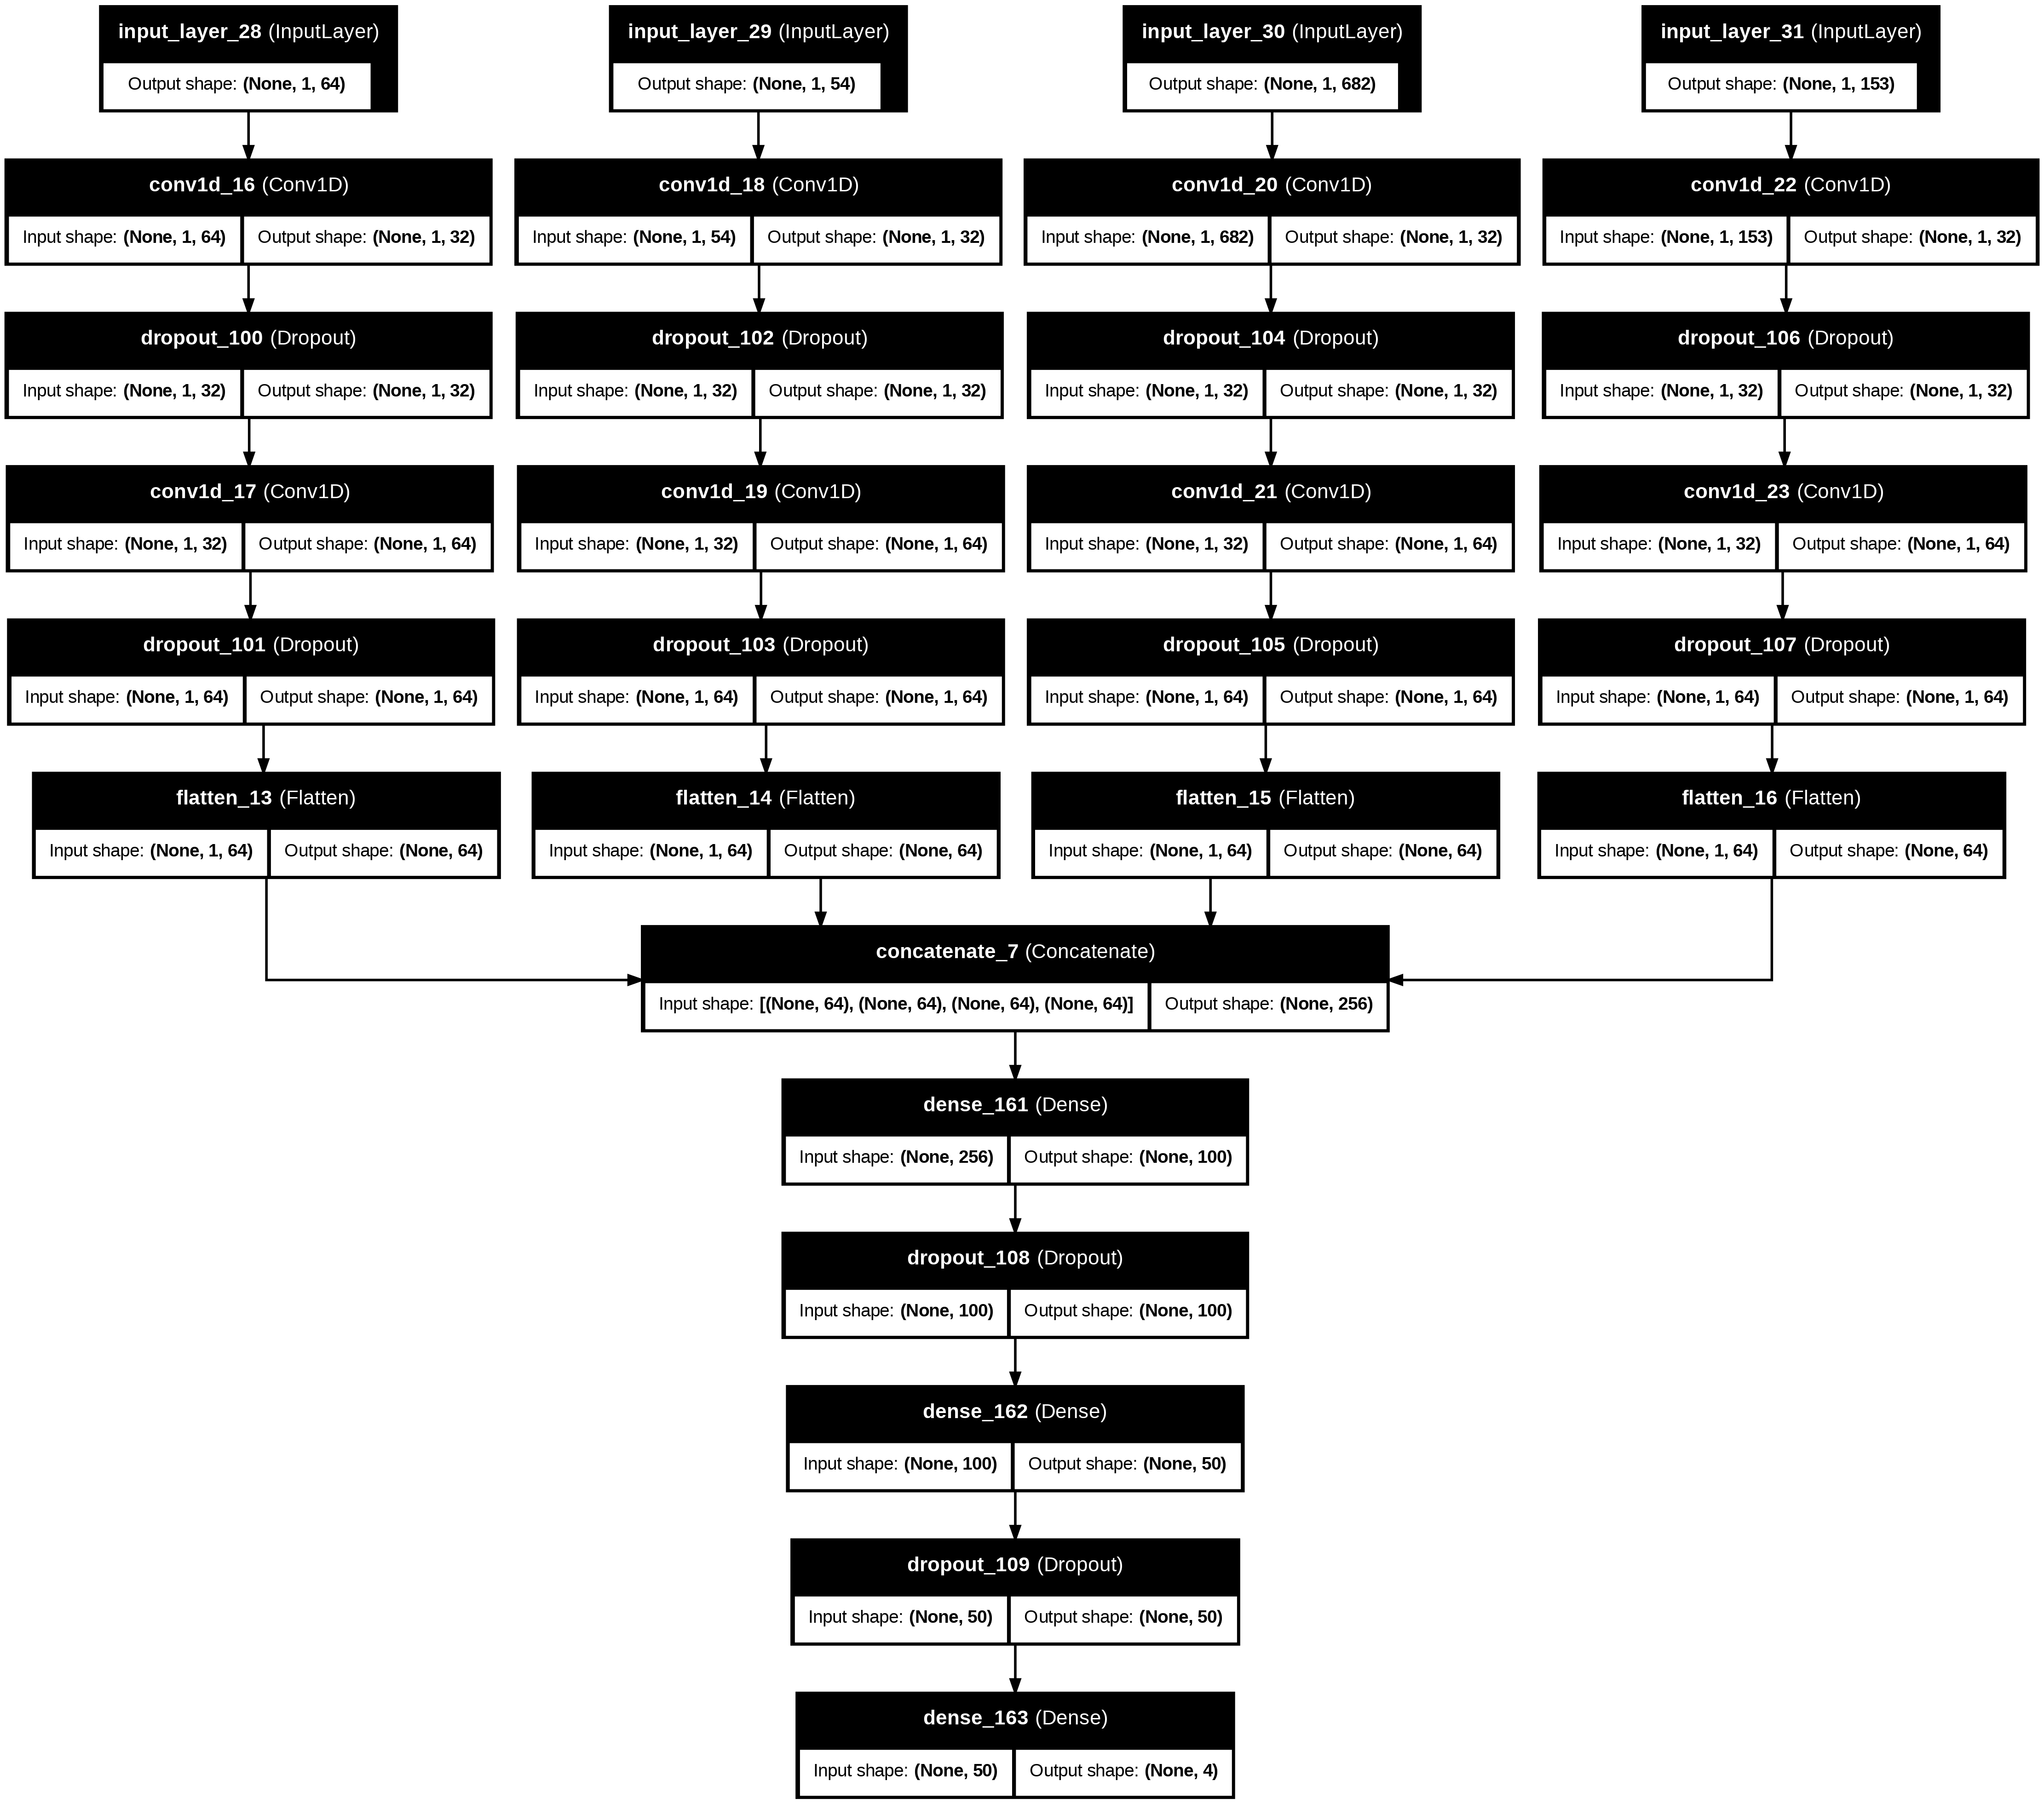

In [ ]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True, show_layer_names=True)

#### LSTM model

In [ ]:
# Define input shapes for the four inputs
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

# Define dense layer configurations
dense_layers_config = [
    {'units': 100, 'activation': 'relu'},
    {'units': 50, 'activation': 'relu'}
]


# Define LSTM layer configurations for the LSTM model
lstm_layers_config = [
    {'units': 64, 'return_sequences': True},
    {'units': 32, 'return_sequences': False}
]

# Create the LSTM model
lstm_model, history_lstm = create_and_train_lstm_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    dropout_rate=0.5,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=10,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)



Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_33            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_34            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_35            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 1, 953)         │              0 │ input_layer_32[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_33[0][0],  │
│                           │                        │                │ input_layer_34[0][0],  │
│                           │                        │                │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1, 64)          │        260,608 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_110 (Dropout)     │ (None, 1, 64)          │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ dropout_110[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_111 (Dropout)     │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_164 (Dense)         │ (None, 100)            │          3,300 │ dropout_111[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_112 (Dropout)     │ (None, 100)            │              0 │ dense_164[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_165 (Dense)         │ (None, 50)             │          5,050 │ dropout_112[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_113 (Dropout)     │ (None, 50)             │              0 │ dense_165[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_166 (Dense)         │ (None, 4)              │            204 │ dropout_113[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 281,578 (1.07 MB)

 Trainable params: 281,578 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5672 - loss: 1.0713 - val_accuracy: 0.8318 - val_loss: 0.5126
Epoch 2/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7665 - loss: 0.6848 - val_accuracy: 0.8942 - val_loss: 0.3879
Epoch 3/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.7993 - loss: 0.6104 - val_accuracy: 0.8928 - val_loss: 0.3980
Epoch 4/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.8081 - loss: 0.5969 - val_accuracy: 0.8893 - val_loss: 0.4016
Epoch 5/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.7939 - loss: 0.6108 - val_accuracy: 0.8744 - val_loss: 0.4602
Epoch 6/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7814 - loss: 0.6439 - val_accuracy: 0.9014 - val_loss: 0.3643
Epoch 7/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.7935 - loss: 0.6201 - val_accuracy: 0.8993 - val_loss: 0.3694
Epoch 8/10
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.8130 - lo

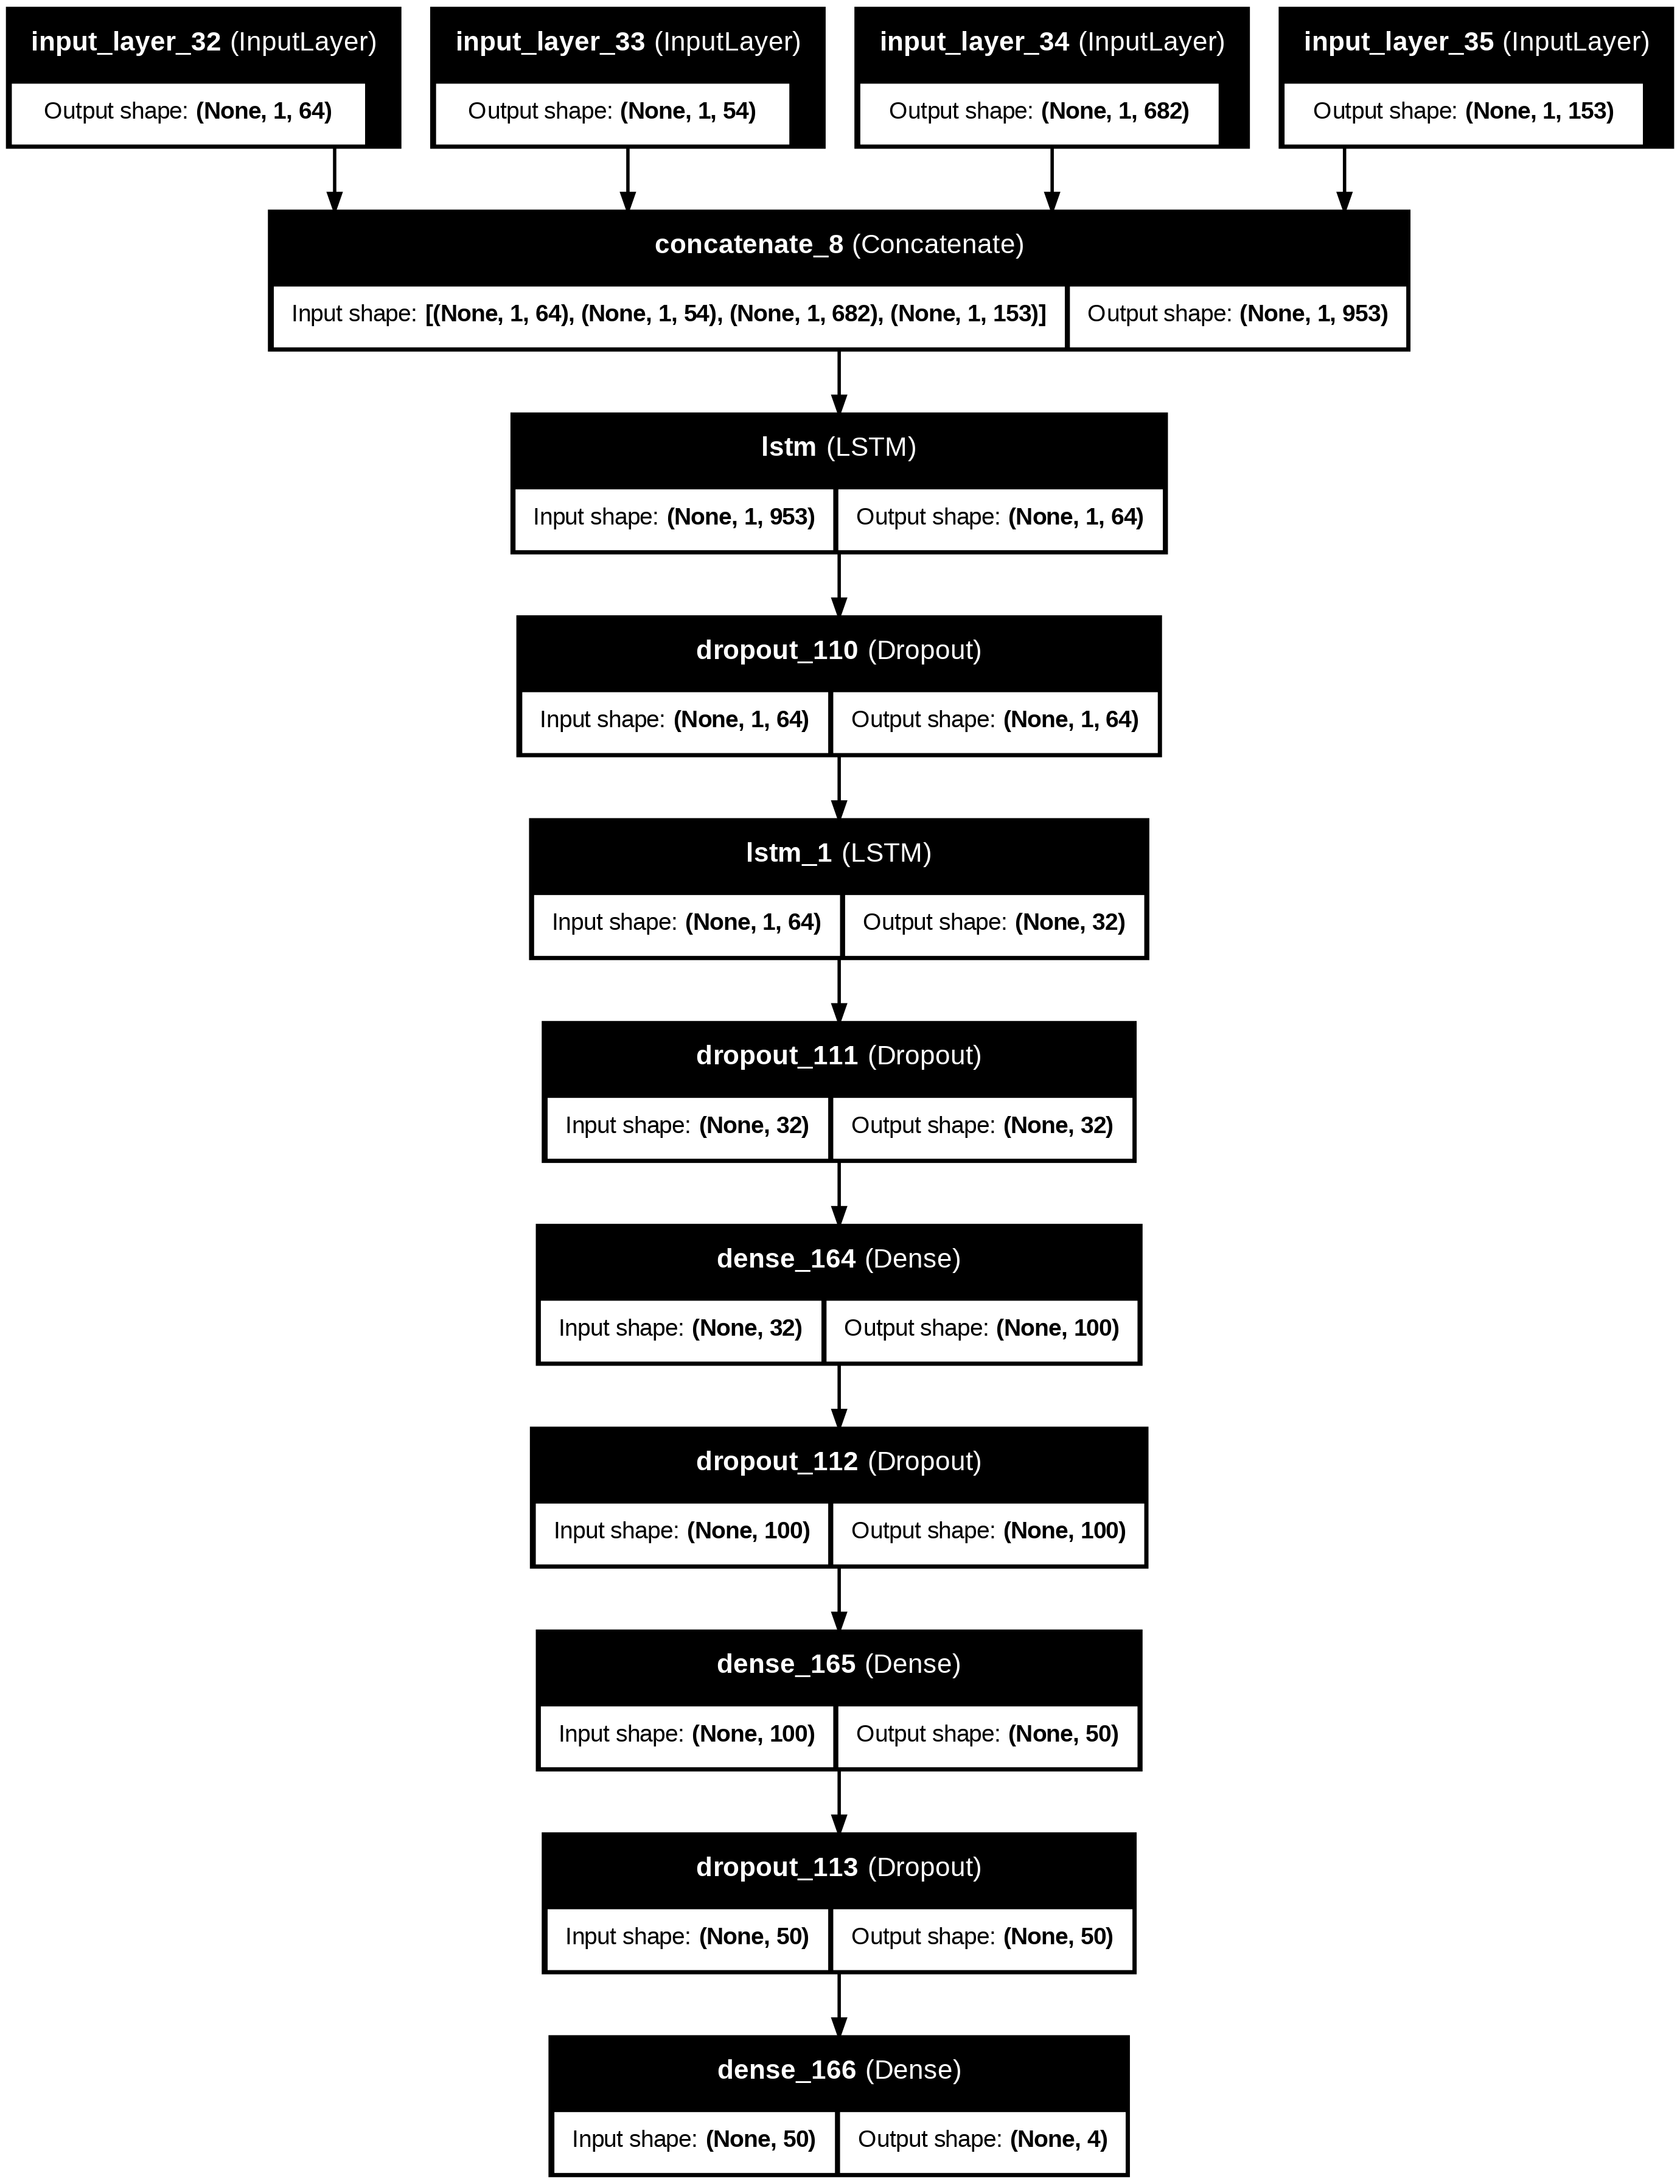

In [ ]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True, show_layer_names=True)

#### Hybrid version between of CNN and LSTM

In [ ]:
input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

# Number of classes for the output
num_classes = len(np.unique(y_train))


# Create the hybrid CNN-LSTM model
hybrid_model, history_hybrid = create_and_train_cnn_lstm_model(
    input_shapes=input_shapes,
    num_classes=num_classes,
    kernel_regularizer=tf.keras.regularizers.l2(0.01),
    dropout_rate=0.5,
    optimizer='adam',
    metrics=['accuracy'],
    validation_split=0.2,
    X_train=[X0_train, X1_train, X2_train, X3_train],
    y_train=y_train,
    epochs=8,
    batch_size=32,
    early_stopping=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
)


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_37            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_38            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_39            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_24 (Conv1D)        │ (None, 1, 16)          │          3,088 │ input_layer_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_25 (Conv1D)        │ (None, 1, 16)          │          2,608 │ input_layer_37[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_26 (Conv1D)        │ (None, 1, 16)          │         32,752 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_27 (Conv1D)        │ (None, 1, 16)          │          7,360 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_114 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_116 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_118 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_120 (Dropout)     │ (None, 1, 16)          │              0 │ conv1d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_114[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_116[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_118[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_120[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_115 (Dropout)     │ (None, 1, 32)          │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_117 (Dropout)

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.5755 - loss: 1.7431 - val_accuracy: 0.9839 - val_loss: 0.3028
Epoch 2/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9115 - loss: 0.5138 - val_accuracy: 0.9839 - val_loss: 0.2418
Epoch 3/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9302 - loss: 0.4265 - val_accuracy: 0.9902 - val_loss: 0.2073
Epoch 4/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9352 - loss: 0.3910 - val_accuracy: 0.9873 - val_loss: 0.1954
Epoch 5/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9380 - loss: 0.3778 - val_accuracy: 0.9896 - val_loss: 0.1911
Epoch 6/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9407 - loss: 0.3663 - val_accuracy: 0.9853 - val_loss: 0.2092
Epoch 7/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9406 - loss: 0.3607 - val_accuracy: 0.9852 - val_loss: 0.1956
Epoch 8/8
2269/2269 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9405 - loss: 0.3624 - 

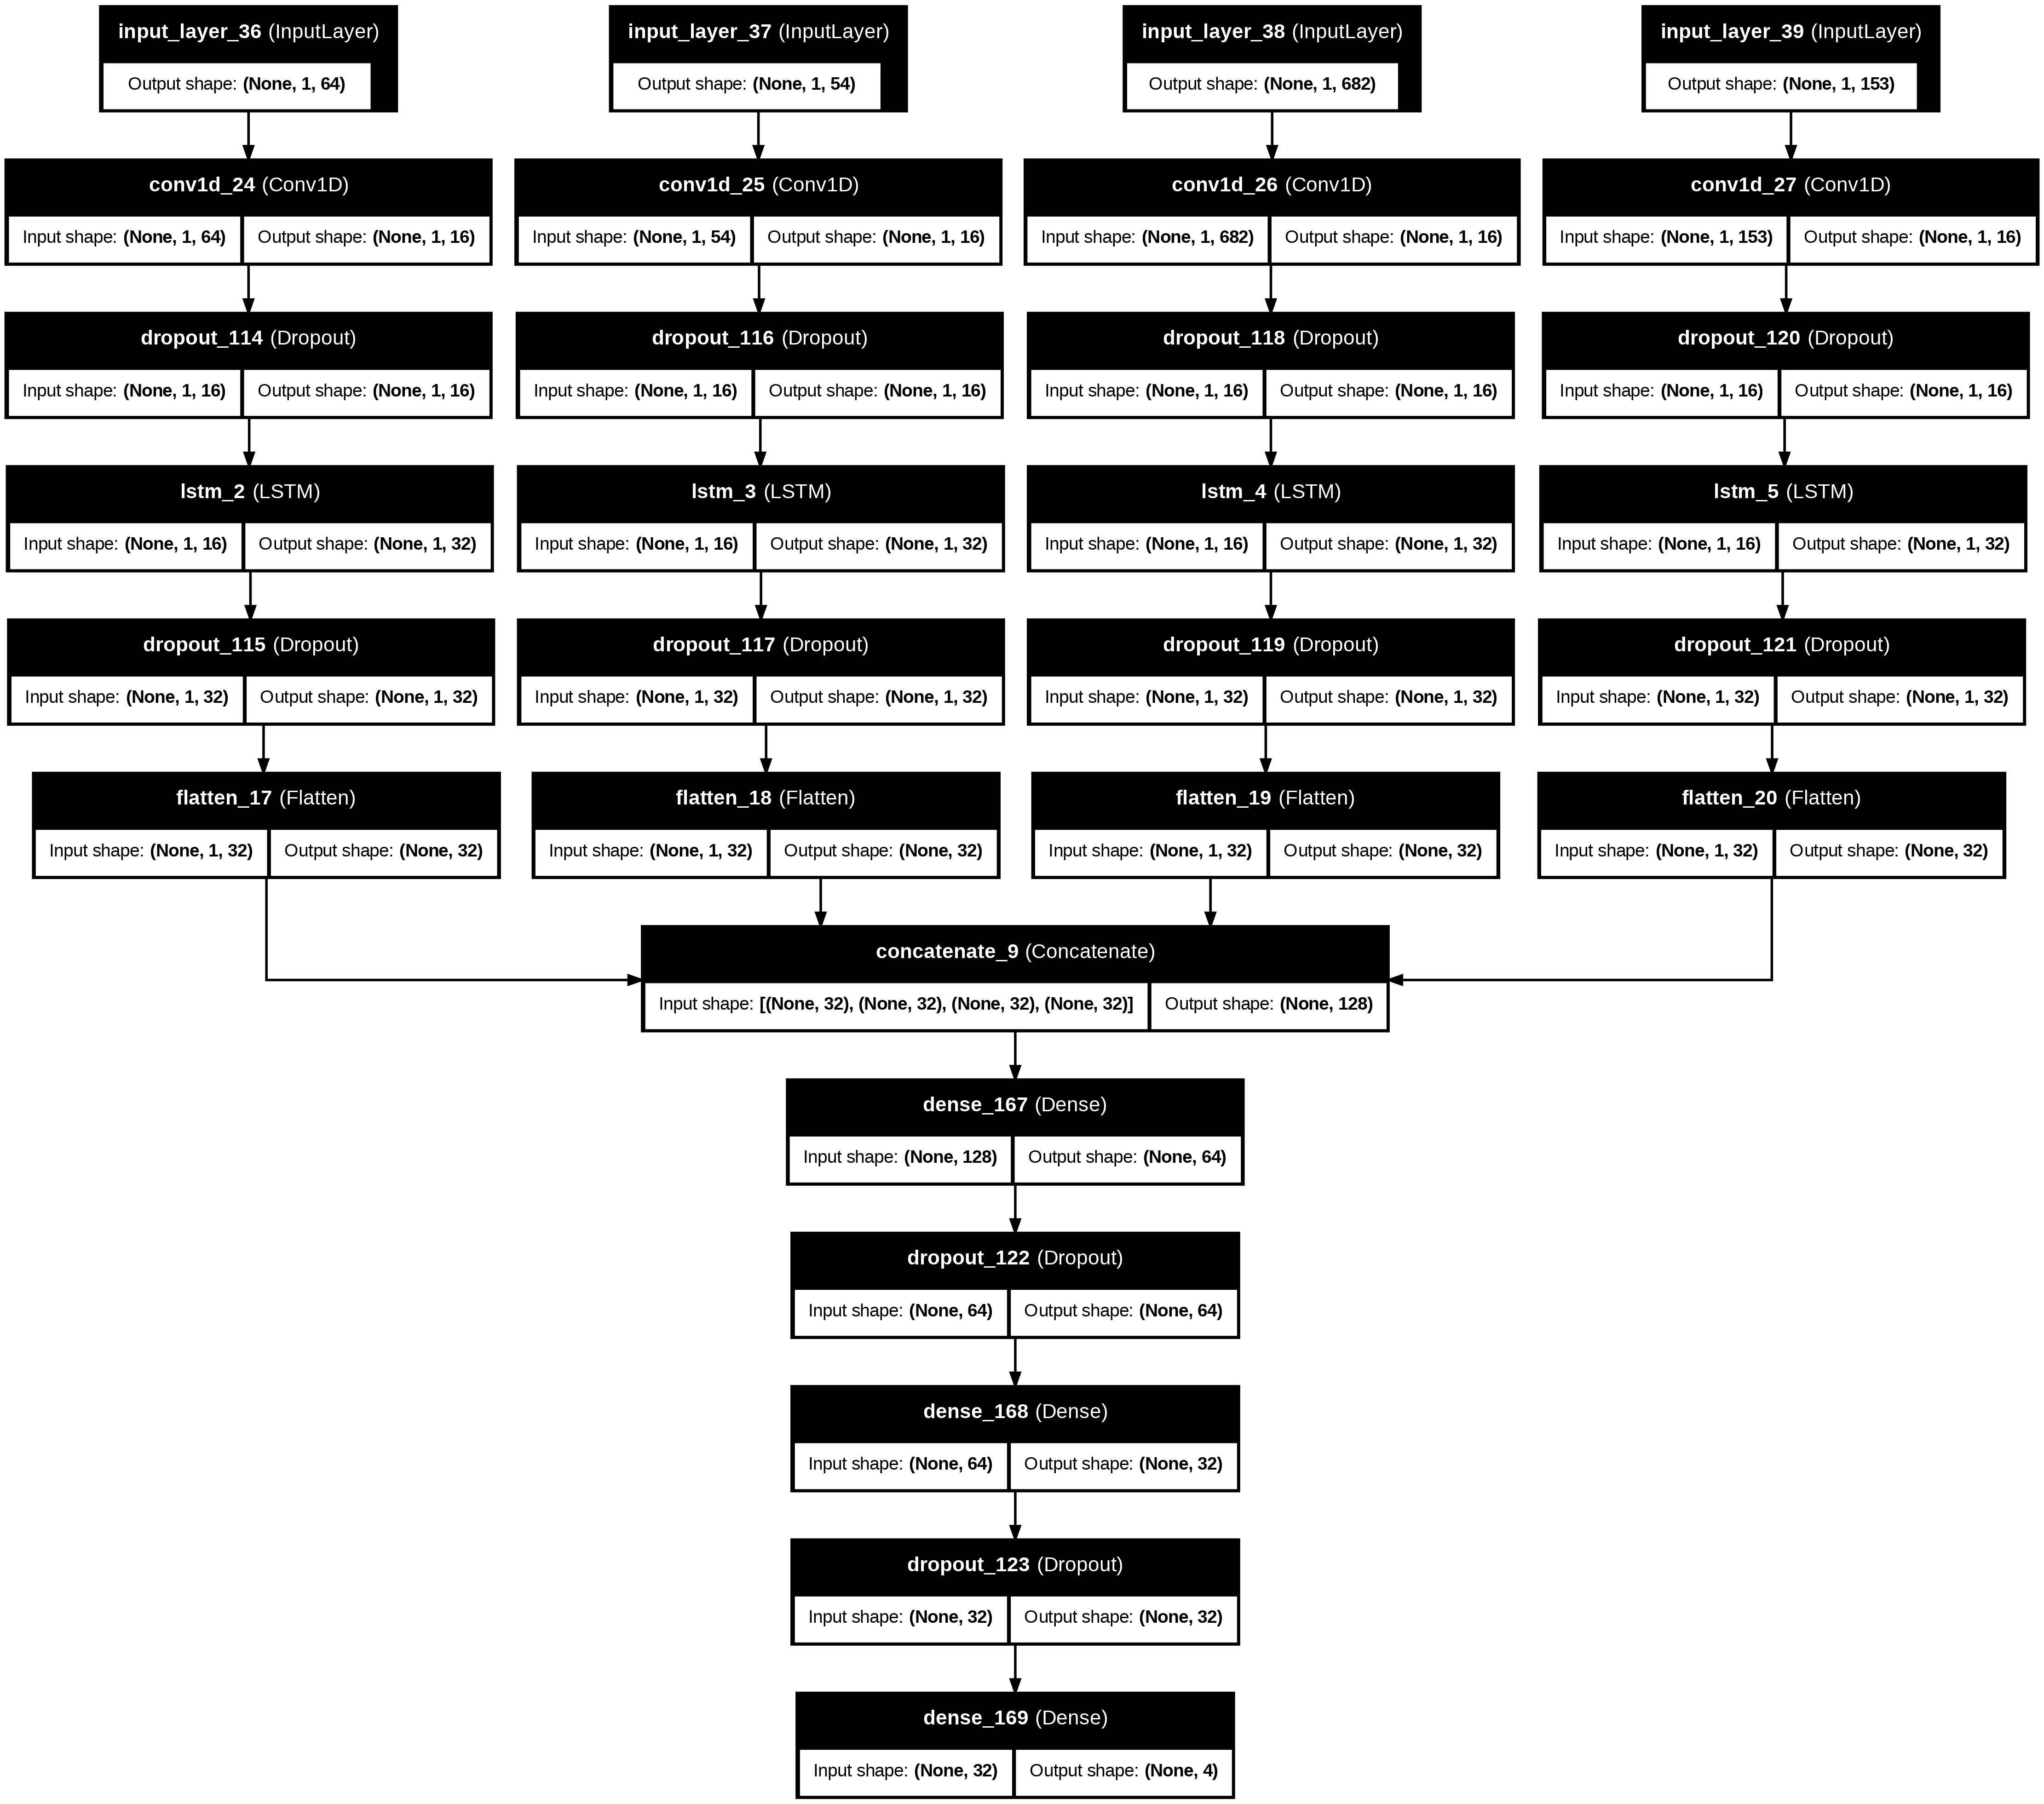

In [ ]:
tf.keras.utils.plot_model(hybrid_model, show_shapes=True, show_layer_names=True)

### Model Evaluation with train_test_split

In [ ]:
# Example models and datasets
models = [model, cnn_model, lstm_model, hybrid_model]
histories = [history, cnn_history, history_lstm, history_hybrid]

models_name= ["Simple", "CNN", "LSTM","hybrid"]
X_tests = [X0_test, X1_test, X2_test, X3_test]  # Test input datasets
y_test = y_test  # Ground truth labels

# Initialize Benchmark class
benchmark = Benchmark(models, histories, models_name)

In [ ]:

# Generate predictions
benchmark.predict_classes(X_tests, y_test)


710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
710/710 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
710/710 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
# Print classification reports
benchmark.print_classification_reports()

Classification Report for Model_Simple:
              precision    recall  f1-score       support
0              0.866367  0.902214  0.883927   6187.000000
1              0.992401  0.984916  0.988644   5171.000000
2              0.945946  0.843451  0.891763   5436.000000
3              0.914486  0.972185  0.942453   5896.000000
accuracy       0.925165  0.925165  0.925165      0.925165
macro avg      0.929800  0.925691  0.926697  22690.000000
weighted avg   0.926659  0.925165  0.924877  22690.000000


Classification Report for Model_CNN:
              precision    recall  f1-score       support
0              0.999190  0.996606  0.997896   6187.000000
1              0.999609  0.989557  0.994558   5171.000000
2              0.998526  0.997057  0.997791   5436.000000
3              0.986772  0.999491  0.993091   5896.000000
accuracy       0.995857  0.995857  0.995857      0.995857
macro avg      0.996024  0.995678  0.995834  22690.000000
weighted avg   0.995900  0.995857  0.995861  22690.

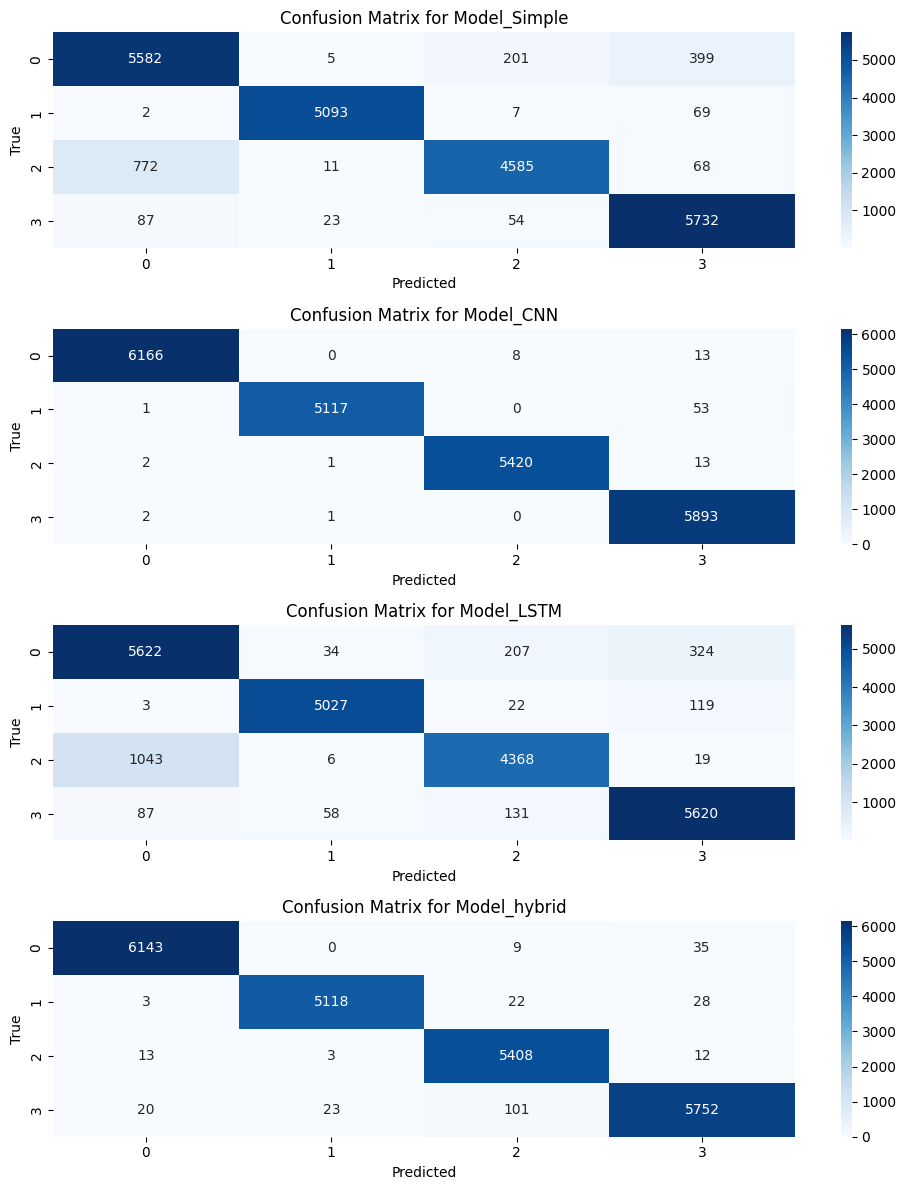

In [ ]:

# Plot confusion matrices
benchmark.plot_confusion_matrices(y_test)


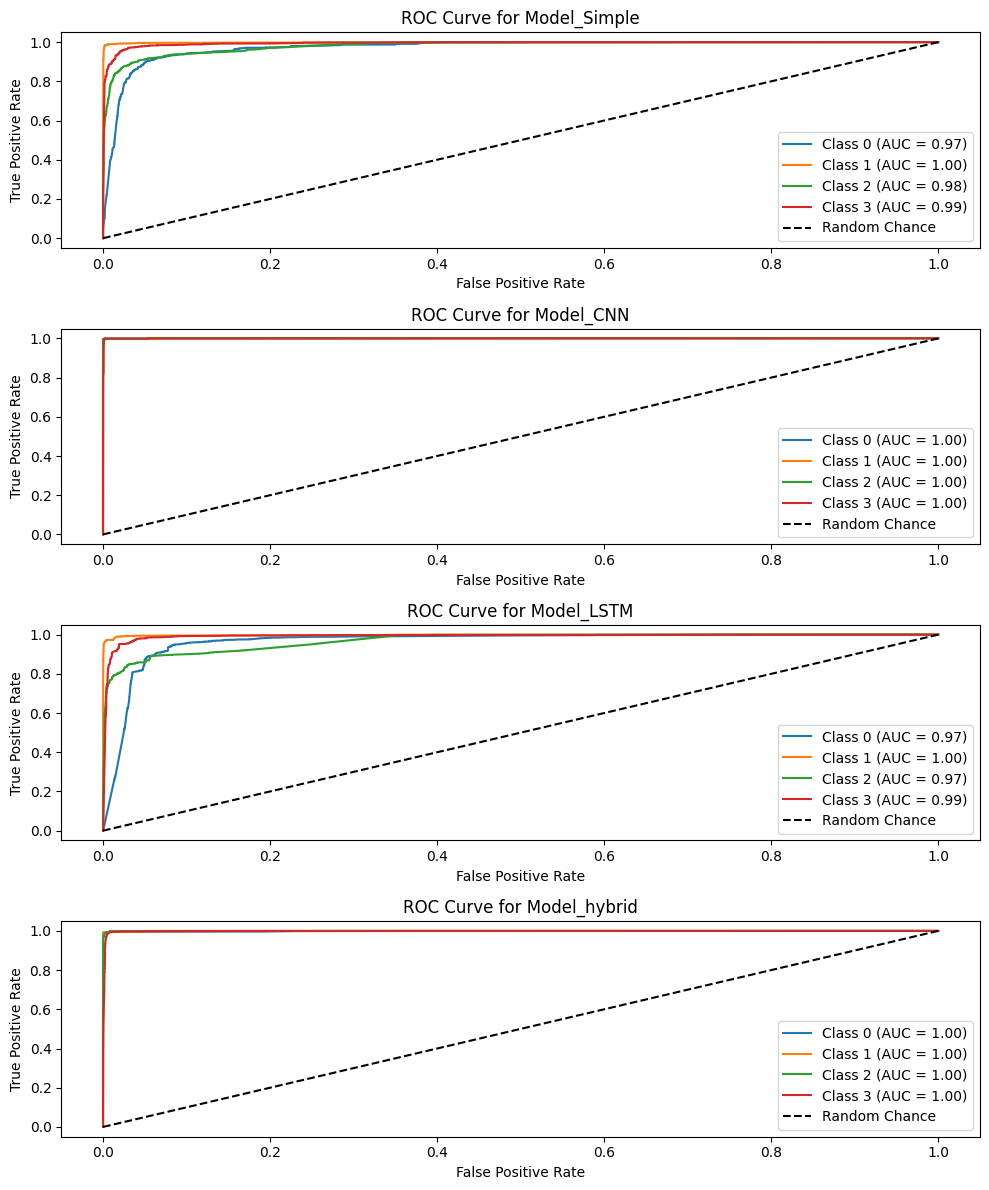

In [ ]:

# Plot ROC curves
benchmark.plot_roc_curves(y_test)


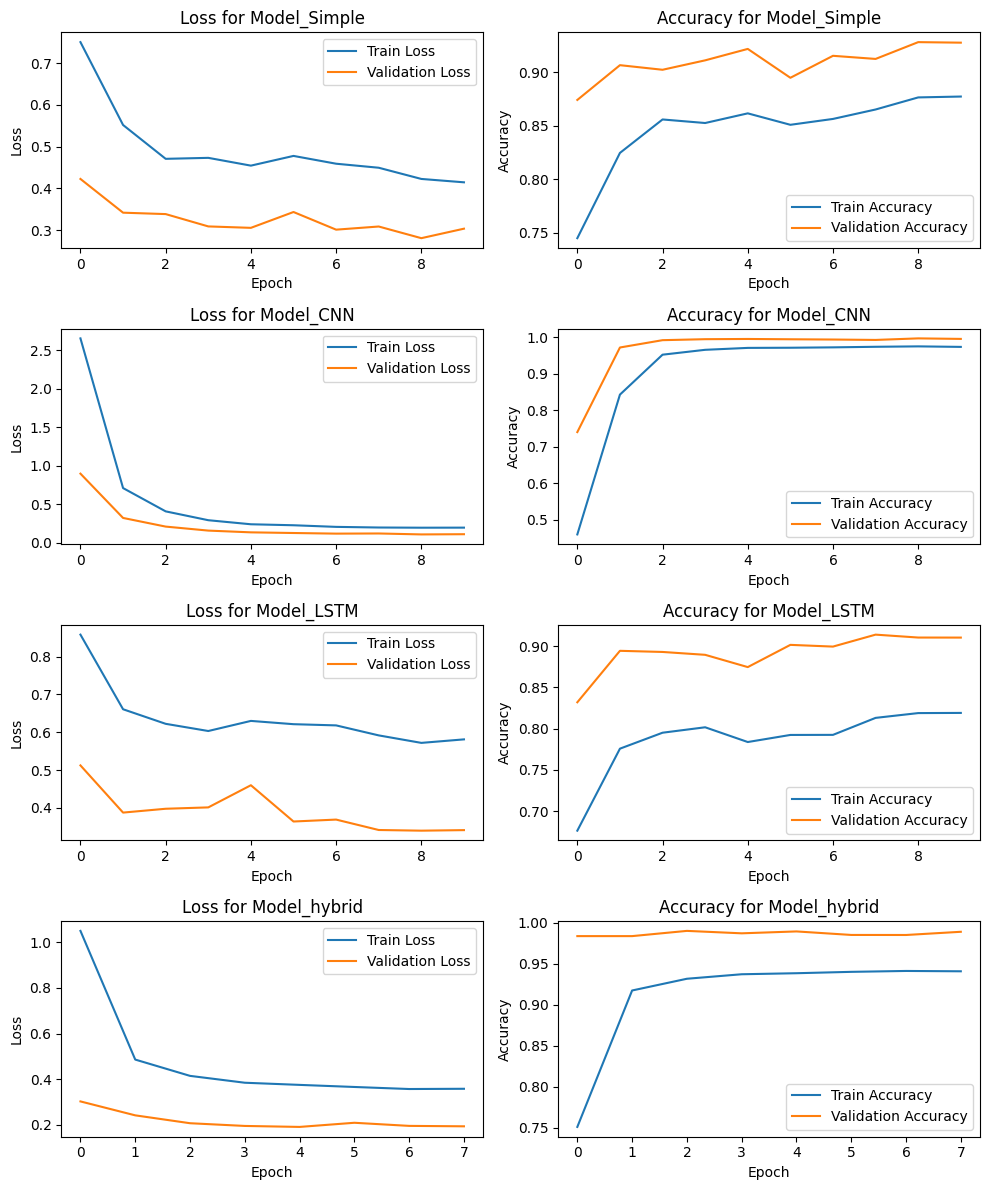

In [ ]:

# Plot training histories
benchmark.plot_training_histories()


### Save Model

In [ ]:
import pickle

# Save model
with open('multi_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Model Optimisation

#### Grid Search

In [ ]:
import itertools
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def grid_search(emg_df, imu_df, ips_df, mocap_df, label_df, person_df,
                split_methods, model_functions, normalization_options, hyperparameter_grid):
    # Results storage
    results = []
    models = []
    histories = []
    # Generate all combinations of hyperparameters
    hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

    # Iterate over normalization options
    for normalize in normalization_options:
        if normalize:
            X, y = load_and_normalize_data(emg_df, imu_df, ips_df, mocap_df, label_df)
            le = LabelEncoder()
            y = le.fit_transform(y)
        else:
            # Load data without normalization
            X, y = load_data(emg_df, imu_df, ips_df, mocap_df, label_df)
            le = LabelEncoder()
            y = le.fit_transform(y)

        # Iterate over split methods
        for split_method in split_methods:
            X_train, X_test, y_train, y_test = preprocess_data_with_split(X, y, split_method, person_df=person_df, test_size=0.2, random_state=42)

            # Get input shapes and number of classes
            input_shapes = [(1, X0_train[0].shape[1]),
                (1, X1_train[0].shape[1]),
                (1, X2_train[0].shape[1]),
                (1, X3_train[0].shape[1])]

            # Number of classes for the output
            num_classes = len(np.unique(y_train))

            # Iterate over model functions (both CNN-LSTM hybrid and simple models)
            for model_func, model_type in model_functions:
                # Iterate over hyperparameter combinations
                for hyperparams in hyperparameter_combinations:
                    # Unpack hyperparameters for this configuration
                    hyperparam_dict = dict(zip(hyperparameter_grid.keys(), hyperparams))

                    # Train the hybrid model (CNN-LSTM)
                    try:
                        model, history = model_func(
                            input_shapes=input_shapes,
                            num_classes=num_classes,
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),
                            dropout_rate=hyperparam_dict.get('dropout_rate', 0.5),
                            optimizer=hyperparam_dict.get('optimizer', 'adam'),
                            metrics=['accuracy'],
                            validation_split=0.2,
                            epochs=hyperparam_dict.get('epochs', 8),
                            batch_size=hyperparam_dict.get('batch_size', 32),
                            X_train=[X_train[0], X_train[1], X_train[2], X_train[3]],
                            y_train=y_train
                        )
                        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

                        # Store results for hybrid model
                        results.append({
                            "normalize": normalize,
                            "split_method": split_method,
                            "model_function": model_func,
                            "model_type": model_type,
                            "hyperparameters": hyperparam_dict,
                            "test_loss": test_loss,
                            "test_accuracy": test_accuracy,
                            "model" : model,
                            "history" : history
                        })

                    except Exception as e:
                        print(f"Error with hybrid model configuration: {hyperparam_dict}, Error: {e}")


    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    return results_df

# Example Usage
split_methods = ["logo_split"]
model_functions = [
    (create_and_train_model, "simple") ,
    (create_and_train_cnn_model, "CNN"),
    (create_and_train_lstm_model, "LSTM"),
     (create_and_train_cnn_lstm_model, "hybrid"),
]
normalization_options = [True]
hyperparameter_grid = {
    "dropout_rate": [0.3],
    "optimizer": ['adam', 'sgd'],
    "epochs": [10],
    "batch_size": [16, 32]
}

results_df = grid_search(df_emg, df_imu, df_ips, df_mocap, label_df, person_df,
                         split_methods, model_functions, normalization_options, hyperparameter_grid)

# Analyze results
print(results_df.sort_values(by="test_accuracy", ascending=False))

Normalizing datasets...
Normalization complete.
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 16}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 32}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'sgd', 'epochs': 10, 'batch_size': 16}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'sgd', 'epochs': 10, 'batch_size': 32}, Error: create_and_train_model() got an unexpected keyword argument 'batch_size'
Error with hybrid model configuration: {'dropout_rate': 0.3, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 16}, Error: create_and_train_cnn_model() got an unexpected keywo

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 64)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1, 16)          │          3,088 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 1, 16)          │          2,608 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 1, 16)          │         32,752 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 1, 16)          │          7,360 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1, 16)          │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1, 16)          │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1, 16)          │              0 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 1, 16)          │              0 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 1, 32)          │          6,272 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1, 32)          │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 1, 32)          │              0 │ lstm_1[0][0]           │
├──────────────────────

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.2788 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2789 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2757 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2757 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - accuracy: 0.2747 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2747 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.2737 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 1, 16)          │          3,088 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 1, 16)          │          2,608 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 1, 16)          │         32,752 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 1, 16)          │          7,360 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 1, 32)          │              0 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout) 

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.2726 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2758 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.2749 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.2765 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.2775 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.2763 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2772 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.2745 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 1, 16)          │          3,088 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 1, 16)          │          2,608 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 1, 16)          │         32,752 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 1, 16)          │          7,360 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 1, 32)          │          6,272 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 1, 32)          │              0 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout) 

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.2756 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2729 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2773 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2741 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2777 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.2755 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 1, 64)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 1, 54)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_14            │ (None, 1, 682)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 1, 153)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 1, 16)          │          3,088 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 1, 16)          │          2,608 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 1, 16)          │         32,752 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 1, 16)          │          7,360 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_30 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_32 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_34 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_36 (Dropout)      │ (None, 1, 16)          │              0 │ conv1d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_30[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_32[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_14 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_34[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_15 (LSTM)            │ (None, 1, 32)          │          6,272 │ dropout_36[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_31 (Dropout)      │ (None, 1, 32)          │              0 │ lstm_12[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_33 (Dropout) 

 Total params: 81,364 (317.83 KB)

 Trainable params: 81,364 (317.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.2740 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 2/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2706 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 3/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2763 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 4/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2763 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 5/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2715 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 6/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.2747 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 7/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.2733 - loss: nan - val_accuracy: 0.2703 - val_loss: nan
Epoch 8/10
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2765 - loss: nan - val_accuracy: 0.2703 - val_loss: nan


In [ ]:
results_df.to_csv(dataset_base_path+'/results_df_version_2.csv', index=False)

# Benchmark

#### Global Performance

In [ ]:
metrics_df_cat_split = pd.read_csv(dataset_base_path+'/metrics_df_cat_split.csv')
metrics_df_logo_split = pd.read_csv(dataset_base_path+'/metrics_df_logo_split.csv')
metrics_df_logo_split_person = pd.read_csv(dataset_base_path+'/metrics_df_train_test_split.csv')
metrics_df_unified= pd.read_csv(dataset_base_path+'/metrics_df_version_2_unified_model.csv')

# concat data
metrics_df = pd.concat([metrics_df_cat_split, metrics_df_logo_split, metrics_df_logo_split_person, metrics_df_unified])
metrics_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1-Score,split_method
1,Model_CNN,0.991847,0.991874,0.991847,0.991848,train_test_split
3,Model_Hybrid,0.981666,0.981858,0.981666,0.981696,train_test_split
0,Model_Simple,0.975804,0.975976,0.975804,0.975794,train_test_split
2,Model_LSTM,0.927766,0.929040,0.927766,0.927575,train_test_split
0,Model_Unified model,0.911572,0.922253,0.911572,0.909175,train_test_split
2,Model_LSTM,0.858991,0.865370,0.858991,0.857143,logo_split
0,Model_Simple,0.852497,0.869468,0.852497,0.853371,logo_split
0,Model_Simple,0.804187,0.816856,0.804187,0.801923,split_data_by_category
2,Model_LSTM,0.733230,0.784563,0.733230,0.729867,split_data_by_category
3,Model_Hybrid,0.732077,0.842518,0.732077,0.720447,logo_split


**The model that performed the best is the CNN multimodal model when the data is shuffled with train_test_split method, and the LSTM model for the logo split.**

#### Grid Search Results for the multimodal

In [ ]:
metrics_df_hybrid_grid_search = pd.read_csv(dataset_base_path+'/results_df_grid_search.csv', index_col=0)
metrics_df_hybrid_grid_search[:-2].head()

,normalize,split_method,model_function,model_type,hyperparameters,test_loss,test_accuracy,model,history
0,True,logo_split,<function create_and_train_cnn_lstm_model at 0...,hybrid,"{'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...",NaN,0.269982,"<Functional name=functional_16, built=True>",<keras.src.callbacks.history.History object at...
1,True,logo_split,<function create_and_train_cnn_lstm_model at 0...,hybrid,"{'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...",NaN,0.269982,"<Functional name=functional_17, built=True>",<keras.src.callbacks.history.History object at...
2,True,logo_split,<function create_and_train_cnn_lstm_model at 0...,hybrid,"{'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...",NaN,0.269982,"<Functional name=functional_18, built=True>",<keras.src.callbacks.history.History object at...
3,True,logo_split,<function create_and_train_cnn_lstm_model at 0...,hybrid,"{'dropout_rate': 0.3, 'optimizer': 'adam', 'ep...",NaN,0.269982,"<Functional name=functional_19, built=True>",<keras.src.callbacks.history.History object at...
4,True,logo_split,<function create_and_train_cnn_lstm_model at 0...,hybrid,"{'dropout_rate': 0.3, 'optimizer': 'sgd', 'epo...",NaN,0.269982,"<Functional name=functional_20, built=True>",<keras.src.callbacks.history.History object at...


#### Grid Search Results for the unified model

In [ ]:
metrics_df_unified_grid_search = pd.read_csv(dataset_base_path+'/results_df_version_1_unified_model.csv', )

,history,model,model_type,split_method
hyperparameters,,,,
"{'dropout_rate': 0.5, 'optimizer': 'adam', 'loss': 'sparse_categorical_crossentropy', 'metrics': ['accuracy'], 'epochs': 8, 'batch_size': 64}",<keras.src.callbacks.history.History object at...,"<Functional name=functional_1, built=True>",unified,logo_split
"{'dropout_rate': 0.2, 'optimizer': 'adam', 'loss': 'sparse_categorical_crossentropy', 'metrics': ['accuracy'], 'epochs': 8, 'batch_size': 32}",<keras.src.callbacks.history.History object at...,"<Functional name=functional_2, built=True>",unified,logo_split
"{'dropout_rate': 0.2, 'optimizer': 'adam', 'loss': 'sparse_categorical_crossentropy', 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 64}",<keras.src.callbacks.history.History object at...,"<Functional name=functional_3, built=True>",unified,logo_split
"{'dropout_rate': 0.2, 'optimizer': 'sgd', 'loss': 'sparse_categorical_crossentropy', 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 64}",<keras.src.callbacks.history.History object at...,"<Functional name=functional_4, built=True>",unified,logo_split
"{'dropout_rate': 0.5, 'optimizer': 'sgd', 'loss': 'sparse_categorical_crossentropy', 'metrics': ['accuracy'], 'epochs': 10, 'batch_size': 32}",<keras.src.callbacks.history.History object at...,"<Functional name=functional_5, built=True>",unified,logo_split
